## Introduction


The prediction of seasonal products is a particular challenge for both data scientist and bakers. While for the latter it is a matter of planning and ensuring early on the need for seasonal ingredients only, so that there is enough for the season, but not too much. If too few ingredients were ordered, the seasonal products would be sold out too early, the company would lose money and, in addition, customers could be alienated in the long term. In turn, overestimating expected sales would also mean losses for the company and food waste that could have been avoided.

As mentioned above, seasonal time series (ts) also pose special challenges for data scientists due to their special (statistical) properties, which not every ML model can easily handle. 
It is precisely these properties that will be examined in more detail in this notebook. Furthermore, it will be examined whether certain properties could be used as an advantage to improve models.

### The data:

kindly provided by Meteolytix:.

They consist of three seasonal bakery products, their daily sales figures with the corresponding date, if they were also sold on that day. The item number, where number one represents an Easter pineapple and numbers 2 & 3 represent two different bakers. In addition, the corresponding branch number, in this case for a bakery in Vienna. 

### Goal:
The aim is to predict the sales figures for 2021, the second pandemic year.


# Import libarys

In [2]:
# general
import numpy as np
import pandas as pd
from datetime import datetime, date

# plot libarys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

# statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung

# further libarys
import warnings

# saveing
import pickle


# Global settings

In [3]:
warnings.filterwarnings('ignore')
RSEED = 1

plt.rcParams['figure.figsize'] = [14, 8]
sns.set_style('whitegrid')#("darkgrid") 
sns.set_palette('cubehelix')

# Load data

In [4]:
df = pd.read_csv('data/meteolytix_dataset_2021.csv', sep=';')
df.head()

Sold On  Branch Number  Article Number Amount Sold
0  2012-01-16            100               1           9
1  2012-01-17            100               1          14
2  2012-01-18            100               1          29
3  2012-01-19            100               1          13
4  2012-01-20            100               1          14

# Data cleaning

## Renaming
Firstly renames all columns after the convention

In [5]:
df.rename(columns={'Sold On':'sold_on', 'Branch Number':'branch','Article Number':'article','Amount Sold':'amount_sold'},inplace=True);
df.columns

Index(['sold_on', 'branch', 'article', 'amount_sold'], dtype='object')

## Checking data types and missing values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5260 entries, 0 to 5259
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sold_on      5260 non-null   object
 1   branch       5260 non-null   int64 
 2   article      5260 non-null   int64 
 3   amount_sold  5260 non-null   object
dtypes: int64(2), object(2)
memory usage: 164.5+ KB


The data has no missing values, but the amount_sold should be Dtype float not object. After looking at the data I found that in some rows ',' is used instead of '.'. 


In [7]:
df[198:200]

sold_on  branch  article amount_sold
198  2013-04-26     100        1          29
199  2013-04-27     100        1        20,5

In [8]:
df['amount_sold'] = df['amount_sold'].str.replace(',','.');
df['amount_sold']= df['amount_sold'].astype('float');
print(df.info())
print( )
df[198:200]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5260 entries, 0 to 5259
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sold_on      5260 non-null   object 
 1   branch       5260 non-null   int64  
 2   article      5260 non-null   int64  
 3   amount_sold  5260 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 164.5+ KB
None



sold_on  branch  article  amount_sold
198  2013-04-26     100        1         29.0
199  2013-04-27     100        1         20.5

## Checking duplicates and NaNs

In [9]:
df.duplicated().sum()

0

In [10]:
df.isna().value_counts()

sold_on  branch  article  amount_sold
False    False   False    False          5260
dtype: int64

=> No duplicates nor NaNs, so no further action needed.

## Unique values

In [11]:
print(df.nunique())
print(f'Unique article values: {df.article.unique()}')
print(f'Branch IDs:{df.branch.unique()}')

sold_on        2373
branch            1
article           3
amount_sold     165
dtype: int64
Unique article values: [1 2 3]
Branch IDs:[100]


The data consist the sales of three articles for one branch with the ID '100'. Since the branch column contains any further information it can be dropped here.

In [12]:
df.drop(columns=['branch'], inplace=True);
df.columns

Index(['sold_on', 'article', 'amount_sold'], dtype='object')

# Feature engineering

## Splitting the time column

Splitting the 'sold_on' column in it's components. 

In [13]:
def date_split(data, d, yn='n'): 
    '''
    - data: ts
    - d : Datumsspalte
    - yn - Option zum löschen ('y') der eingangsspalte
    '''

    data = data.assign(
        timestamp = lambda x: pd.to_datetime(x[d]), 
        date = lambda x: x['timestamp'].dt.date,
        year = lambda x: x['timestamp'].dt.year,
        month = lambda x: x['timestamp'].dt.month,
        week = lambda x: x['timestamp'].dt.week,
        day = lambda x: x['timestamp'].dt.day,
        dayofyear = lambda x: x['timestamp'].dt.dayofyear,
        weekday = lambda x: x['timestamp'].dt.dayofweek,
    )
    
    if yn == 'y':
        data.drop(columns=[d], inplace=True);

    return data

In [14]:
df = date_split(df, 'sold_on', 'y')
df.info
print( )
df.head(2)

article  amount_sold  timestamp        date  year  month  week  day  \
0        1          9.0 2012-01-16  2012-01-16  2012      1     3   16   
1        1         14.0 2012-01-17  2012-01-17  2012      1     3   17   

   dayofyear  weekday  
0         16        0  
1         17        1

## Create separate ts for the different articles

In [15]:
df_one = df.query('article == 1') 
df_one.drop(columns=['article'], inplace=True);
df_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917 entries, 0 to 916
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   amount_sold  917 non-null    float64       
 1   timestamp    917 non-null    datetime64[ns]
 2   date         917 non-null    object        
 3   year         917 non-null    int64         
 4   month        917 non-null    int64         
 5   week         917 non-null    int64         
 6   day          917 non-null    int64         
 7   dayofyear    917 non-null    int64         
 8   weekday      917 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 71.6+ KB


In [16]:
df_one.describe(datetime_is_numeric=True).T

count                           mean                  min  \
amount_sold  917.0                      70.126499                  0.0   
timestamp      917  2016-04-07 17:08:34.285714432  2012-01-16 00:00:00   
year         917.0                     2016.08615               2012.0   
month        917.0                       2.678299                  1.0   
week         917.0                      10.043621                  2.0   
day          917.0                      16.392585                  1.0   
dayofyear    917.0                       66.91385                 13.0   
weekday      917.0                       2.989095                  0.0   

                             25%                  50%                  75%  \
amount_sold                 45.0                 65.0                 91.0   
timestamp    2014-02-14 00:00:00  2016-03-15 00:00:00  2018-04-11 00:00:00   
year                      2014.0               2016.0               2018.0   
month                        2.0                  3.0                  4.0   
week                         6.0                 10.0                 14.0   
day                          9.0                 17.0                 24.0   
dayofyear                   41.0                 67.0                 92.0   
weekday                      1.0                  3.0                  5.0   

                             max        std  
amount_sold                203.0  33.169043  
timestamp    2021-01-28 00:00:00        NaN  
year                      2021.0   2.672477  
month                        5.0   1.035451  
week                        18.0   4.275994  
day                         31.0   8.647807  
dayofyear                  123.0   29.76869  
weekday                      6.0   1.989023

In [17]:
df_two = df.query('article == 2') 
df_two.drop(columns=['article'], inplace=True);
df_two.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2181 entries, 917 to 3097
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   amount_sold  2181 non-null   float64       
 1   timestamp    2181 non-null   datetime64[ns]
 2   date         2181 non-null   object        
 3   year         2181 non-null   int64         
 4   month        2181 non-null   int64         
 5   week         2181 non-null   int64         
 6   day          2181 non-null   int64         
 7   dayofyear    2181 non-null   int64         
 8   weekday      2181 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 170.4+ KB


In [18]:
df_two.describe(datetime_is_numeric=True).T

count                           mean                  min  \
amount_sold  2181.0                      17.740945                  0.0   
timestamp      2181  2016-09-09 00:56:07.262723584  2012-01-02 00:00:00   
year         2181.0                    2016.249885               2012.0   
month        2181.0                       5.804677                  1.0   
week         2181.0                      23.461715                  1.0   
day          2181.0                      15.729023                  1.0   
dayofyear    2181.0                     161.427785                  1.0   
weekday      2181.0                        3.02155                  0.0   

                             25%                  50%                  75%  \
amount_sold                 13.0                 16.0                 20.0   
timestamp    2014-06-24 00:00:00  2016-10-12 00:00:00  2018-12-11 00:00:00   
year                      2014.0               2016.0               2018.0   
month                        2.0                  4.0                 10.0   
week                         8.0                 17.0                 44.0   
day                          8.0                 16.0                 23.0   
dayofyear                   56.0                116.0                302.0   
weekday                      1.0                  3.0                  5.0   

                             max         std  
amount_sold                188.0   12.260675  
timestamp    2021-03-17 00:00:00         NaN  
year                      2021.0    2.604408  
month                       12.0    4.022802  
week                        53.0   17.568608  
day                         31.0    8.667266  
dayofyear                  366.0  122.959544  
weekday                      6.0    2.000228

In [19]:
df_three = df.query('article == 3') 
df_three.drop(columns=['article'], inplace=True);
df_three.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2162 entries, 3098 to 5259
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   amount_sold  2162 non-null   float64       
 1   timestamp    2162 non-null   datetime64[ns]
 2   date         2162 non-null   object        
 3   year         2162 non-null   int64         
 4   month        2162 non-null   int64         
 5   week         2162 non-null   int64         
 6   day          2162 non-null   int64         
 7   dayofyear    2162 non-null   int64         
 8   weekday      2162 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 168.9+ KB


In [20]:
df_three.describe(datetime_is_numeric=True).T

count                           mean                  min  \
amount_sold  2162.0                       9.359389                  0.0   
timestamp      2162  2016-06-22 22:56:43.515263488  2012-01-02 00:00:00   
year         2162.0                    2016.024052               2012.0   
month        2162.0                       5.947271                  1.0   
week         2162.0                      24.092507                  1.0   
day          2162.0                      15.748844                  1.0   
dayofyear    2162.0                     165.816836                  1.0   
weekday      2162.0                       3.024052                  0.0   

                             25%                  50%                  75%  \
amount_sold                  6.0                  9.0                 12.0   
timestamp    2013-12-17 06:00:00  2016-04-03 12:00:00  2018-12-31 18:00:00   
year                      2013.0               2016.0              2018.75   
month                        2.0                  4.0                 10.0   
week                         8.0                 17.0                 44.0   
day                          8.0                 16.0                 23.0   
dayofyear                   56.0                118.0               303.75   
weekday                      1.0                  3.0                  5.0   

                             max         std  
amount_sold                 70.0     5.23867  
timestamp    2021-03-17 00:00:00         NaN  
year                      2021.0     2.80219  
month                       12.0    4.084258  
week                        53.0   17.838152  
day                         31.0    8.630484  
dayofyear                  366.0  124.801887  
weekday                      6.0    2.000781

+ The data suggest that article one has the highest peaks in demand, possibly because it has the shortest sales time.

+ It also shows that for both max sales and percentiles, the second item appears to enjoy greater popularity than the third article. To understand this, one would have to know the exact nature of the Berilner and probably try it first 

+ In addition, it shows that the given data of **article one only last until 01.28.2021, while the others last until 03.17.2021**. With the knowledge of the later plots, it is unlikely that it was the end of the season, maybe it was due to an update delay or whatever else reason. 


+ **It can already be stated here that all time series are univariate & are not continuous**


## Create a data Frame with gaps filled with zeros

Create a DataFrame with filled gaps hence it's unclear whether the later model would improve from this.

Those gaps represent no missing data, the representing article simply wasn't sold on those days, so the gaps will be replaced with zeros.

In [21]:
print(f'start date article one {df_one.date.min()} and end date {df_one.date.max()}')
print(f'start date article two {df_two.date.min()} and end date {df_two.date.max()}')
print(f'start date article three {df_three.date.min()} and end date {df_three.date.max()}')

start date article one 2012-01-16 and end date 2021-01-28
start date article two 2012-01-02 and end date 2021-03-17
start date article three 2012-01-02 and end date 2021-03-17


In [22]:
df_one_zero = df_one.copy()
# define range of the time series
r_one = pd.date_range(start = df_one.date.min(), end = df_one.date.max())

# redefine the index (which is the date or sold_on column)
# fill the created missing values with zeros and rename back
df_one_zero = df_one_zero.set_index('date').reindex(r_one).fillna(0.0).rename_axis('date').reset_index()

# Correcting the various dates related columns, without this step all date related columns expect 'date' would also be filled with zeros
df_one_zero = date_split(df_one_zero, 'date')

In [23]:
df_one_zero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3301 entries, 0 to 3300
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3301 non-null   object        
 1   amount_sold  3301 non-null   float64       
 2   timestamp    3301 non-null   datetime64[ns]
 3   year         3301 non-null   int64         
 4   month        3301 non-null   int64         
 5   week         3301 non-null   int64         
 6   day          3301 non-null   int64         
 7   dayofyear    3301 non-null   int64         
 8   weekday      3301 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 232.2+ KB


In [24]:
# Statistic for the zero filled ts of article one
df_one_zero.describe().T

count         mean         std     min     25%     50%     75%  \
amount_sold  3301.0    19.480763   35.948593     0.0     0.0     0.0    30.0   
year         3301.0  2016.060588    2.604186  2012.0  2014.0  2016.0  2018.0   
month        3301.0     6.500151    3.460042     1.0     3.0     7.0    10.0   
week         3301.0    26.535292   15.112078     1.0    13.0    27.0    40.0   
day          3301.0    15.757346    8.797256     1.0     8.0    16.0    23.0   
dayofyear    3301.0   182.532263  105.754103     1.0    91.0   182.0   274.0   
weekday      3301.0     2.998182    2.000151     0.0     1.0     3.0     5.0   

                max  
amount_sold   203.0  
year         2021.0  
month          12.0  
week           53.0  
day            31.0  
dayofyear     366.0  
weekday         6.0

In [25]:
# Statistic for the original ts of article one
df_one.describe().T

count         mean        std     min     25%     50%     75%  \
amount_sold  917.0    70.126499  33.169043     0.0    45.0    65.0    91.0   
year         917.0  2016.086150   2.672477  2012.0  2014.0  2016.0  2018.0   
month        917.0     2.678299   1.035451     1.0     2.0     3.0     4.0   
week         917.0    10.043621   4.275994     2.0     6.0    10.0    14.0   
day          917.0    16.392585   8.647807     1.0     9.0    17.0    24.0   
dayofyear    917.0    66.913850  29.768690    13.0    41.0    67.0    92.0   
weekday      917.0     2.989095   1.989023     0.0     1.0     3.0     5.0   

                max  
amount_sold   203.0  
year         2021.0  
month           5.0  
week           18.0  
day            31.0  
dayofyear     123.0  
weekday         6.0

As expected, it distorts the statistics, but that's irrelevant since we just want to see later if they work better in the models than the original with the unfilled seasonal gaps.

Repeat the process for the other articles:

In [26]:
df_two_zero = df_two.copy()
r_two = pd.date_range(start = df_two.date.min(), end = df_two.date.max())

df_two_zero = df_two_zero.set_index('date').reindex(r_two).fillna(0.0).rename_axis('date').reset_index()

df_two_zero = date_split(df_two_zero, 'date')
df_two_zero.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3363 entries, 0 to 3362
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3363 non-null   object        
 1   amount_sold  3363 non-null   float64       
 2   timestamp    3363 non-null   datetime64[ns]
 3   year         3363 non-null   int64         
 4   month        3363 non-null   int64         
 5   week         3363 non-null   int64         
 6   day          3363 non-null   int64         
 7   dayofyear    3363 non-null   int64         
 8   weekday      3363 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 236.6+ KB


In [27]:
df_three_zero = df_three.copy()
r_three = pd.date_range(start = df_three.date.min(), end = df_three.date.max())

df_three_zero = df_three_zero.set_index('date').reindex(r_three).fillna(0.0).rename_axis('date').reset_index()

df_three_zero = date_split(df_three_zero, 'date')
df_three.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2162 entries, 3098 to 5259
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   amount_sold  2162 non-null   float64       
 1   timestamp    2162 non-null   datetime64[ns]
 2   date         2162 non-null   object        
 3   year         2162 non-null   int64         
 4   month        2162 non-null   int64         
 5   week         2162 non-null   int64         
 6   day          2162 non-null   int64         
 7   dayofyear    2162 non-null   int64         
 8   weekday      2162 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 168.9+ KB


The data suggests a seasonality (increase of data points compared to before) in all three articles, the biggest in the first one, which is just as expected.

'Note: TThis variant of filling in gaps has not proved useful in the course of the project, neither in the representation nor in the models (most models that have problems with gaps also have this with many zero values or very small values).
Therefore they are not considered further here

## Interpolation

Another possibility and probably the most widely used to fill gaps is interpolation. Depending on how long the desired forecast is, it is possible that data points are generated for areas for which there should actually be nothing.The gaps must therefore be recalculated afterwards.

The procedure is completely analogous to the procedure in which gaps were filled with zeros, except that now NaNs are inserted and replaced by interpolated values in the next step.

There are many different methods to interpolate data as this is time based data, pandas time method is used.

In [28]:
df_one_interp = df_one.copy()
r_one = pd.date_range(start=df_one.date.min(), end=df_one.date.max(), freq='1d')

df_one_interp = df_one_interp.set_index('date').reindex(r_one).fillna(np.nan).rename_axis('date').reset_index()

df_one_interp = date_split(df_one_interp, 'date')
df_one_interp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3301 entries, 0 to 3300
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3301 non-null   object        
 1   amount_sold  917 non-null    float64       
 2   timestamp    3301 non-null   datetime64[ns]
 3   year         3301 non-null   int64         
 4   month        3301 non-null   int64         
 5   week         3301 non-null   int64         
 6   day          3301 non-null   int64         
 7   dayofyear    3301 non-null   int64         
 8   weekday      3301 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 232.2+ KB


In [29]:
df_one_interp.shape

(3301, 9)

In [30]:
df_one_interp = df_one_interp.set_index('timestamp')
df_one_interp = df_one_interp.assign(InterpolateTime=df_one_interp.amount_sold.interpolate(method='time')) # method 'time' only works for ts with a datetime type as index
df_one_interp.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3301 entries, 2012-01-16 to 2021-01-28
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             3301 non-null   object 
 1   amount_sold      917 non-null    float64
 2   year             3301 non-null   int64  
 3   month            3301 non-null   int64  
 4   week             3301 non-null   int64  
 5   day              3301 non-null   int64  
 6   dayofyear        3301 non-null   int64  
 7   weekday          3301 non-null   int64  
 8   InterpolateTime  3301 non-null   float64
dtypes: float64(2), int64(6), object(1)
memory usage: 257.9+ KB


In [31]:
df_one_interp.query('month== 6') # viewing a month without sales, which has now values

date  amount_sold  year  month  week  day  dayofyear  \
timestamp                                                                
2012-06-01  2012-06-01          NaN  2012      6    22    1        153   
2012-06-02  2012-06-02          NaN  2012      6    22    2        154   
2012-06-03  2012-06-03          NaN  2012      6    22    3        155   
2012-06-04  2012-06-04          NaN  2012      6    23    4        156   
2012-06-05  2012-06-05          NaN  2012      6    23    5        157   
...                ...          ...   ...    ...   ...  ...        ...   
2020-06-26  2020-06-26          NaN  2020      6    26   26        178   
2020-06-27  2020-06-27          NaN  2020      6    26   27        179   
2020-06-28  2020-06-28          NaN  2020      6    26   28        180   
2020-06-29  2020-06-29          NaN  2020      6    27   29        181   
2020-06-30  2020-06-30          NaN  2020      6    27   30        182   

            weekday  InterpolateTime  
timestamp                             
2012-06-01        4        30.278195  
2012-06-02        5        30.255639  
2012-06-03        6        30.233083  
2012-06-04        0        30.210526  
2012-06-05        1        30.187970  
...             ...              ...  
2020-06-26        4        55.570312  
2020-06-27        5        55.562500  
2020-06-28        6        55.554688  
2020-06-29        0        55.546875  
2020-06-30        1        55.539062  

[270 rows x 9 columns]

In [32]:
df_one_interp.query('month== 2') # viewing a month with sales => original and interpolated column have the same entries


date  amount_sold  year  month  week  day  dayofyear  \
timestamp                                                                
2012-02-01  2012-02-01         32.0  2012      2     5    1         32   
2012-02-02  2012-02-02         30.0  2012      2     5    2         33   
2012-02-03  2012-02-03         30.0  2012      2     5    3         34   
2012-02-04  2012-02-04         13.0  2012      2     5    4         35   
2012-02-05  2012-02-05         21.0  2012      2     5    5         36   
...                ...          ...   ...    ...   ...  ...        ...   
2020-02-25  2020-02-25         94.0  2020      2     9   25         56   
2020-02-26  2020-02-26         81.0  2020      2     9   26         57   
2020-02-27  2020-02-27         99.0  2020      2     9   27         58   
2020-02-28  2020-02-28         90.0  2020      2     9   28         59   
2020-02-29  2020-02-29        100.0  2020      2     9   29         60   

            weekday  InterpolateTime  
timestamp                             
2012-02-01        2             32.0  
2012-02-02        3             30.0  
2012-02-03        4             30.0  
2012-02-04        5             13.0  
2012-02-05        6             21.0  
...             ...              ...  
2020-02-25        1             94.0  
2020-02-26        2             81.0  
2020-02-27        3             99.0  
2020-02-28        4             90.0  
2020-02-29        5            100.0  

[255 rows x 9 columns]

In [33]:
df_one_interp.drop(columns=['amount_sold'], inplace=True)
df_one_interp.rename(columns={'InterpolateTime':'amount_sold'}, inplace=True); 
df_one_interp.reset_index;

In [34]:
def inter(ts):
    r = pd.date_range(start=ts.date.min(), end=ts.date.max(), freq='1d')
    ts = ts.set_index('date').reindex(r).fillna(np.nan).rename_axis('date').reset_index()
    ts = date_split(ts, 'date')
    
    ts = ts.set_index('timestamp')
    ts = ts.assign(InterpolateTime=ts.amount_sold.interpolate(method='time')) 
    
    ts.drop(columns=['amount_sold'], inplace=True)
    ts.rename(columns={'InterpolateTime':'amount_sold'}, inplace=True); 
    ts.reset_index(level=['timestamp'], inplace=True) # to be uniformly with the rest

    return ts

In [35]:
df_two_interp = inter(df_two)
df_three_interp = inter(df_three)

## Logarithmized ts

As shown below in 'Normal distribution and outlier detection', some of the ts are skewed.
One way to remedy this is to logarithmise.

In [36]:
def logs(ts):
    ts_out = ts.copy()
    ts_out['amount_sold'] = np.log(ts_out['amount_sold'])
    ts_out['amount_sold'] = ts_out['amount_sold'].replace([np.inf, -np.inf], 0)
    return ts_out

In [37]:
df_two_log = logs(df_two)
df_three_log = logs(df_three)

In [38]:
df_two_interp_log = logs(df_two_interp)
df_three_interp_log = logs(df_three_interp)

The different ts were created partly because different models have different requirements and partly because it is not possible at this point to foresee what changes the individual models might benefit from.

## Create daily DataFrames 
These ts are created solely for a better representation of the python decomposition later on.

In [39]:
# For the normal DataFrames
df_one_daily = df_one \
    .groupby(['date', 'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'amount_sold': np.mean}) \
    .set_index('date')

df_two_daily = df_two \
    .groupby(['date', 'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'amount_sold': np.mean}) \
    .set_index('date')

df_three_daily = df_three \
    .groupby(['date', 'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'amount_sold': np.mean}) \
    .set_index('date')

# EDA

## 3.1 Course of the time series

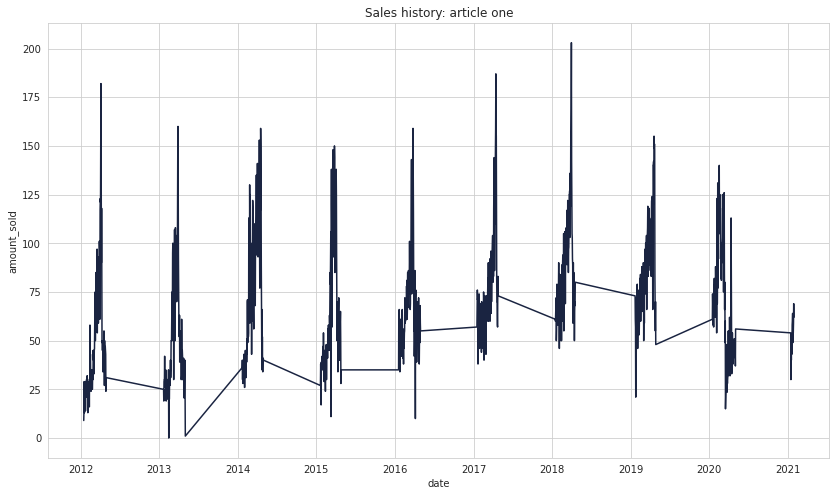

In [40]:
sns.lineplot(data=df_one, y='amount_sold', x='date')
plt.title('Sales history: article one')
plt.savefig('images/sales_history_A1.png')
plt.show()

The figure of the first article shows really well that it only has one season per year (in spring), the straight lines in between represent the gaps, without sales.

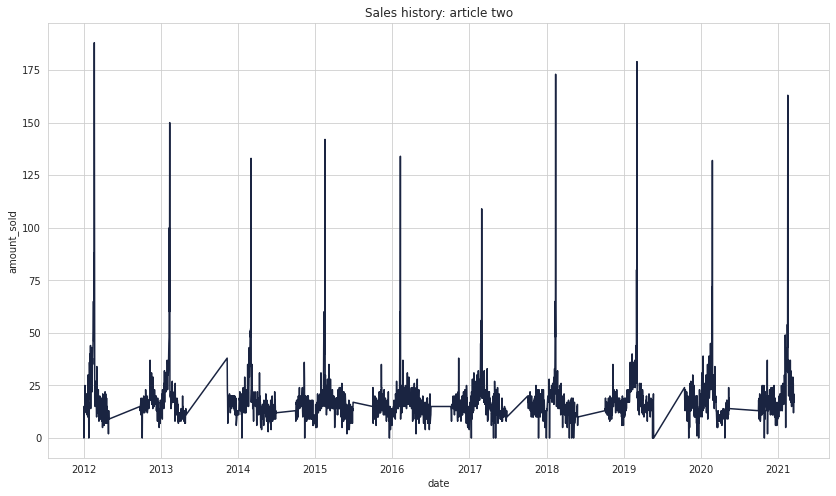

In [41]:
sns.lineplot(data=df_two, y='amount_sold', x='date')
plt.title('Sales history: article two')
plt.savefig('images/sales_history_A2.png')
plt.show()

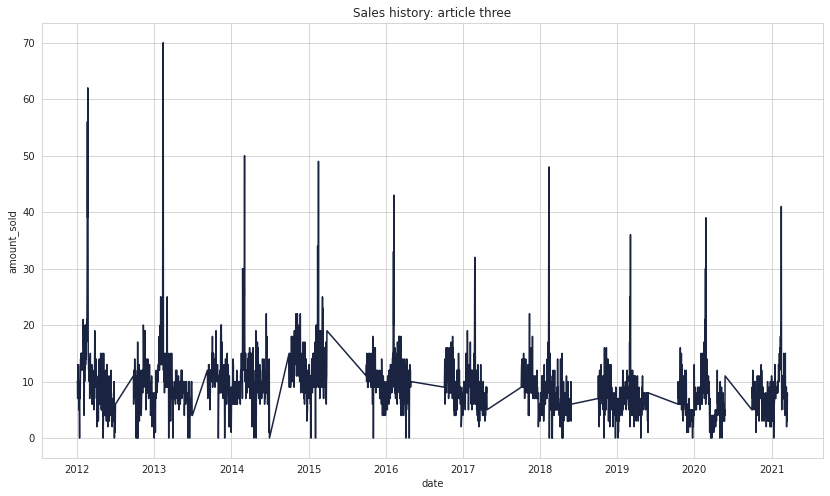

In [42]:
sns.lineplot(data=df_three, y='amount_sold', x='date')
plt.title('Sales history: article three')
plt.savefig('images/sales_history_A3.png')
plt.show()

The ts plots for article two & three show the same seasonality, one big peak at the beginning of the year (probably around carnival) and another one near the end of the year (probably November).

It also can be seen, that the season length varies over the years, e.g. article three, the straight line for 2016 is visible longer than for
the season in 2013, the straight lines between are again the times with no sales for the representing articles.

Note: Unlike sns, Pandas and R drag ts with gaps together and map the gaps less well.

## Monthly sales distribution 

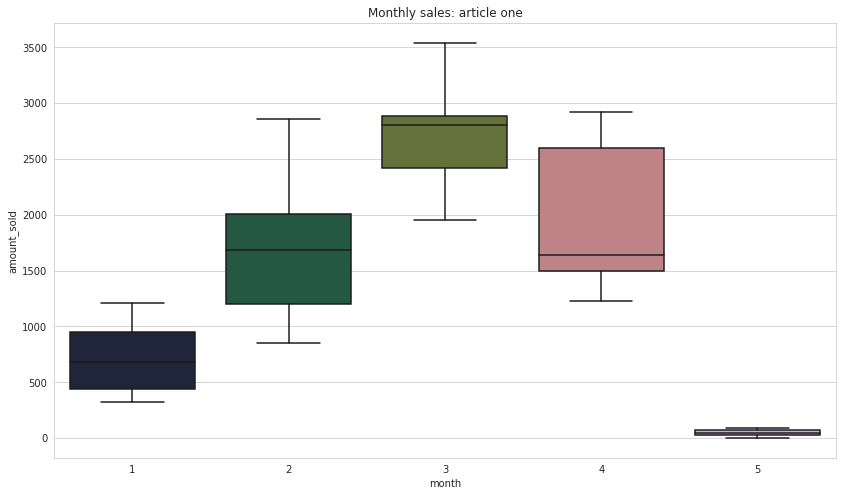

In [43]:
fig, ax = plt.subplots()
df_one \
    .groupby(['year', 'month'], as_index=False) \
    .agg({'amount_sold': np.sum}) \
    .pipe((sns.boxplot, 'data'), 
        x='month', 
        y='amount_sold', 
        #hue='year', 
        ax=ax
    )
ax.set(title='Monthly sales: article one')
plt.savefig('images/monthly_sales_A1.png');

In [44]:
df_one.groupby('month').agg({'year':'unique'}).query('month == 5')

year
month              
5      [2013, 2020]

In [45]:
df_one.groupby('month').agg({'year':'unique'})

year
month                                                   
1      [2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...
2      [2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...
3      [2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...
4      [2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...
5                                           [2013, 2020]

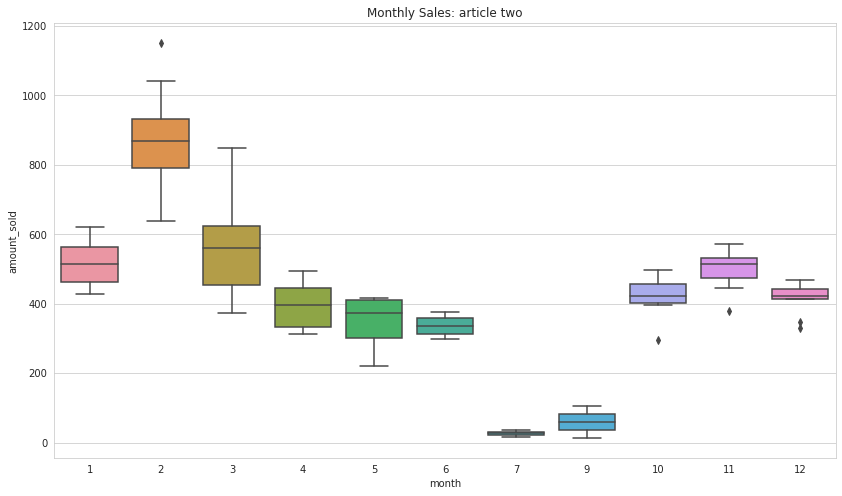

In [46]:
fig, ax = plt.subplots()
df_two \
    .groupby(['year', 'month'], as_index=False) \
    .agg({'amount_sold': np.sum}) \
    .pipe((sns.boxplot, 'data'), 
        x='month', 
        y='amount_sold', 
        #hue='year', 
        ax=ax
    )
ax.set(title='Monthly Sales: article two')
plt.savefig('images/monthly_sales_A2.png');

In [47]:
df_two.groupby('month').agg({'year':'unique'})

year
month                                                   
1      [2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...
2      [2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...
3      [2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...
4      [2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...
5             [2014, 2015, 2016, 2017, 2018, 2019, 2020]
6                               [2014, 2015, 2016, 2017]
7                                           [2015, 2016]
9                                           [2012, 2020]
10      [2012, 2014, 2015, 2016, 2017, 2018, 2020, 2019]
11     [2012, 2013, 2014, 2015, 2017, 2018, 2016, 202...
12     [2012, 2013, 2014, 2015, 2016, 2017, 2018, 202...

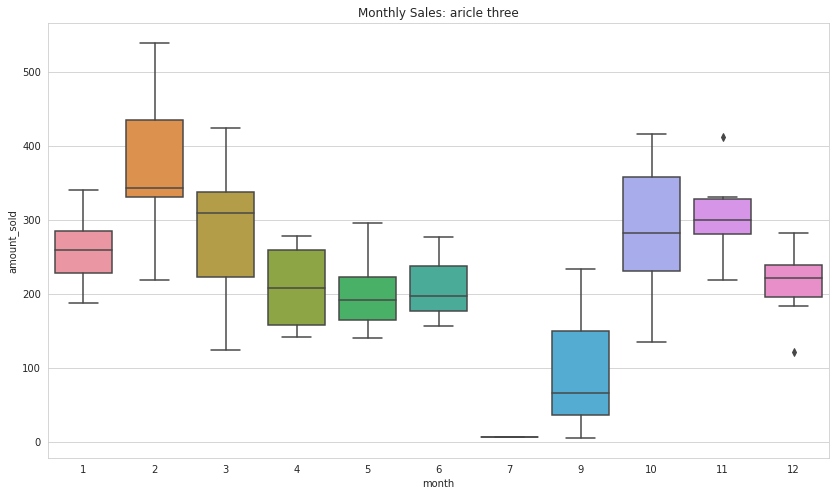

In [48]:
fig, ax = plt.subplots()
df_three \
    .groupby(['year', 'month'], as_index=False) \
    .agg({'amount_sold': np.sum}) \
    .pipe((sns.boxplot, 'data'), 
        x='month', 
        y='amount_sold', 
        #hue='year', 
        ax=ax
        
    )
ax.set(title='Monthly Sales: aricle three')
plt.savefig('images/monthly_sales_A3.png');

In [49]:
df_three.groupby('month').agg({'year':'unique'})

year
month                                                   
1      [2012, 2013, 2015, 2016, 2017, 2018, 2019, 202...
2      [2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...
3      [2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...
4       [2012, 2013, 2014, 2016, 2017, 2018, 2019, 2020]
5                   [2012, 2013, 2014, 2018, 2019, 2020]
6                                     [2012, 2013, 2014]
7                                                 [2012]
9                                     [2012, 2013, 2020]
10     [2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...
11     [2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...
12     [2012, 2013, 2014, 2015, 2016, 2017, 2018, 201...

Looking at the monthly sales through the years gives a very good overview of the seasons of the items.

According to the distribution, article one is usually sold from January to April, with its peak in March, and only in exceptional cases (2013 & 2020) is it also offered in May.

The sesonal pattern for the other two ts is similar, both having their highest sales in February and another smaller peak around November. Moreover, both are only exceptionally sold in the months from May to September, while they are only exceptionally not offered in December.

The biggest difference at first sight seems to be September, where it seems that the article 3 has been sold much more often over the years or offered in more years. However, on closer inspection, it is only one year more and the difference is mainly only due to the different y-axis scaling. This, in turn, seems to be due to the generally higher popularity of the article 2, at least according to the data.  The size of the quartiles would also be more similar if both were scaled equally, although the seasonality of article 3 would then no longer be so clearly recognisable.

## Weekly sales over the year

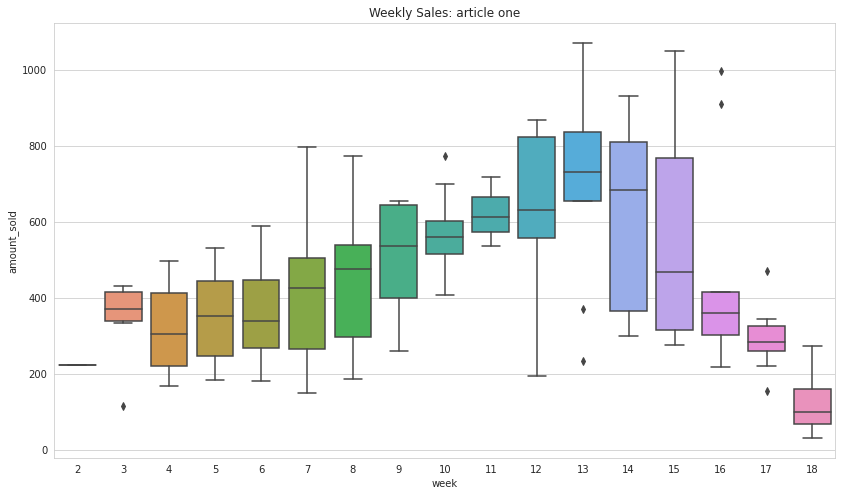

In [50]:
fig, ax = plt.subplots()
df_one \
    .groupby(['year', 'week'], as_index=False) \
    .agg({'amount_sold': np.sum}) \
    .pipe((sns.boxplot, 'data'), 
        x='week', 
        y='amount_sold', 
        #hue='year', 
        ax=ax
    )
ax.set(title='Weekly Sales: article one')
plt.savefig('images/weekly_sales_A1.png');

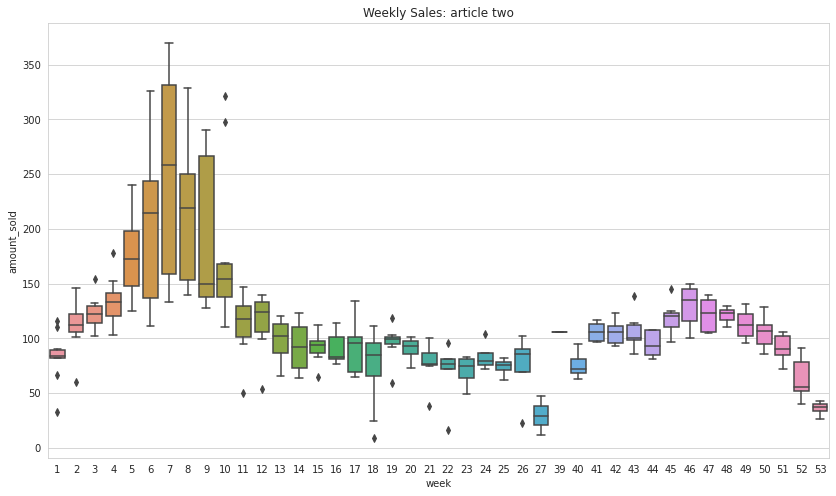

In [51]:
fig, ax = plt.subplots()
df_two \
    .groupby(['year', 'week'], as_index=False) \
    .agg({'amount_sold': np.sum}) \
    .pipe((sns.boxplot, 'data'), 
        x='week', 
        y='amount_sold', 
        #hue='year', 
        ax=ax
    )
ax.set(title='Weekly Sales: article two')
plt.savefig('images/weekly_sales_A2.png');

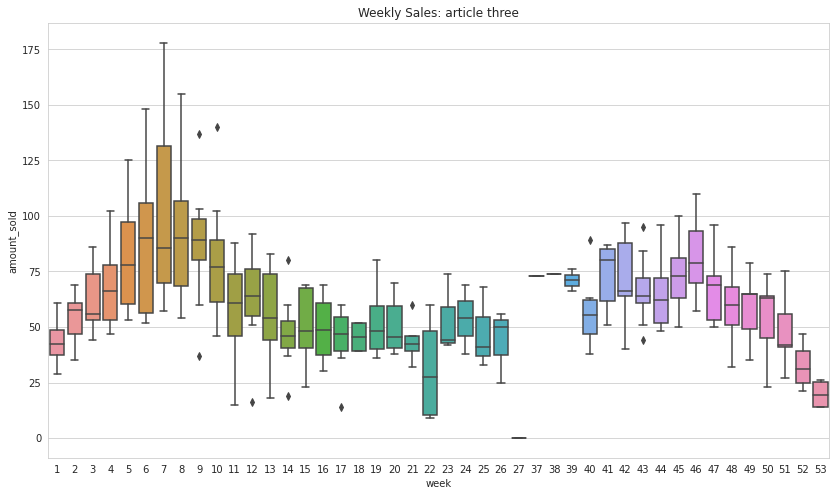

In [52]:
fig, ax = plt.subplots()
df_three \
    .groupby(['year', 'week'], as_index=False) \
    .agg({'amount_sold': np.sum}) \
    .pipe((sns.boxplot, 'data'), 
        x='week', 
        y='amount_sold', 
        #hue='year', 
        ax=ax
    )
ax.set(title='Weekly Sales: article three')
plt.savefig('images/weekly_sales_A3.png');

The seasonal effects already found in the previous plots can be observed here as well. 

## Sales distribution over the weekdays

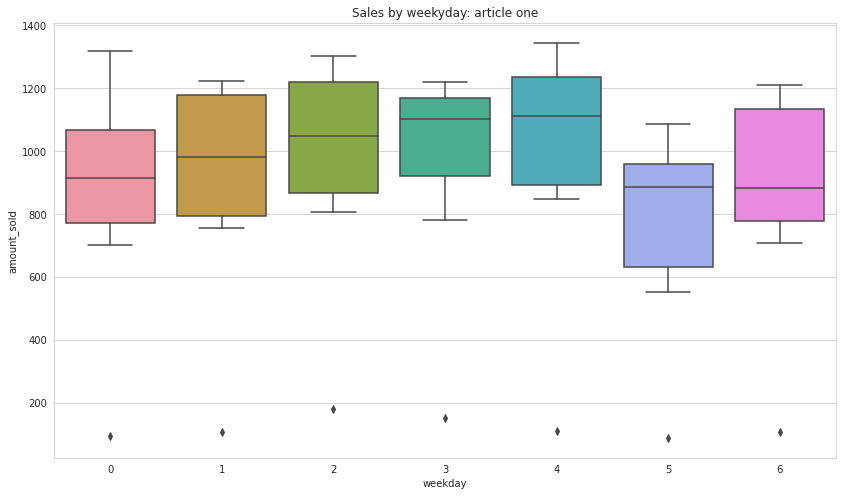

In [53]:
fig, ax = plt.subplots()
df_one \
    .groupby(['year', 'weekday'], as_index=False) \
    .agg({'amount_sold': np.sum}) \
    .pipe((sns.boxplot, 'data'), 
        x='weekday', 
        y='amount_sold', 
        #hue='year', 
        ax=ax
    )
ax.set(title='Sales by weekyday: article one')
plt.savefig('images/weekday_sales_A1.png');

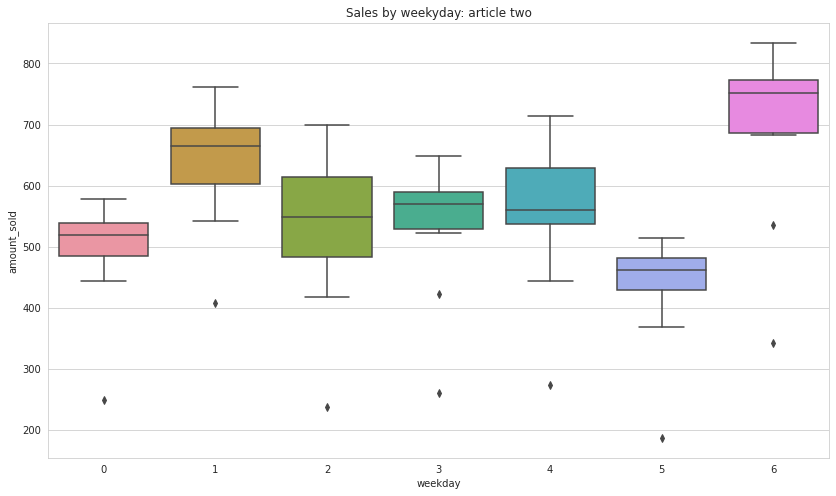

In [54]:
fig, ax = plt.subplots()
df_two \
    .groupby(['year', 'weekday'], as_index=False) \
    .agg({'amount_sold': np.sum}) \
    .pipe((sns.boxplot, 'data'), 
        x='weekday', 
        y='amount_sold', 
        #hue='year', 
        ax=ax
    )
ax.set(title='Sales by weekyday: article two')
plt.savefig('images/weekday_sales_A2.png');

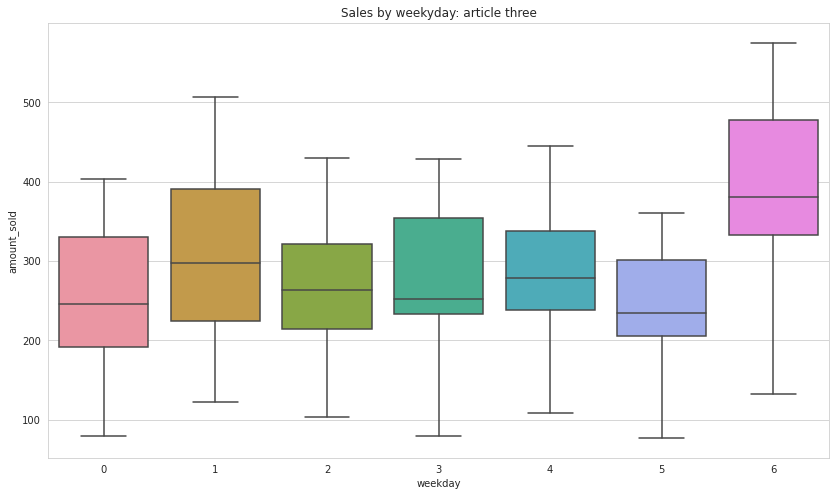

In [55]:
fig, ax = plt.subplots()
df_three \
    .groupby(['year', 'weekday'], as_index=False) \
    .agg({'amount_sold': np.sum}) \
    .pipe((sns.boxplot, 'data'), 
        x='weekday', 
        y='amount_sold', 
        #hue='year', 
        ax=ax
    )
ax.set(title='Sales by weekyday: article three')
plt.savefig('images/weekday_sales_A3.png');

In the distribution of the sales figures over the days of the week (starting at 0 for Monday), the most interesting thing is that, totally different from the others, only article one does not seem to have significantly higher sales figures on Sundays. 
In general, for this article it is fairly evenly distributed over the different days.

While for article two it is almost wave-like, with comparatively lower sales figures on Mondays, Thursdays and especially Saturdays.

In all observations (starting with the monthly ones), only very few outliers can be seen. 

## Special offer
From 05.02.2020 to 03.03.2020 for article one.

In [56]:
# get dayofyear for specific date for filter
day_of_year = date(2020, 2, 5).timetuple().tm_yday
print("Day of year: ", day_of_year, "\n")

day_of_year = date(2020, 3, 3).timetuple().tm_yday
print("Day of year: ", day_of_year, "\n")

Day of year:  36 

Day of year:  63 



In [57]:
#  get the time interval for the special offer
filtered2 = df_one.query('dayofyear >= 36  & dayofyear <= 63 & year >= 2017')

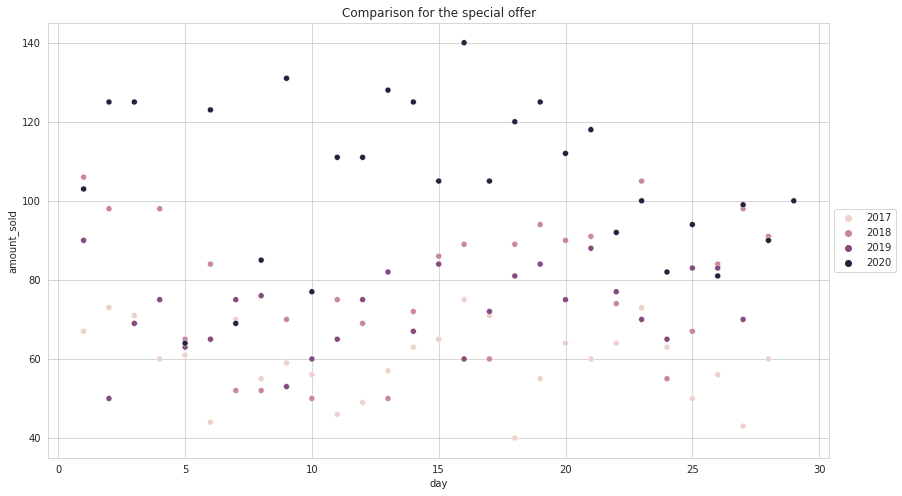

In [58]:
fig, ax = plt.subplots()
filtered2 \
    .groupby(['year', 'day'], as_index=False) \
    .agg({'amount_sold': np.sum}) \
    .pipe((sns.scatterplot, 'data'), 
        x='day', 
        y='amount_sold', 
        hue='year',
        #ax=ax
    );
ax.set(title='Comparison for the special offer');
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.savefig('images/speciel offer_A1.png');
plt.show()

In [59]:
offer = df_one.query('dayofyear >= 36  & dayofyear <= 63 & year == 2020').amount_sold.mean()

vgl = df_one.query('dayofyear >= 36  & dayofyear <= 63 & year == 2019').amount_sold.mean()

round(((offer-vgl)/offer)*100,2)

30.37

The plot of the offer time in 2020 compared to the recent years bevor shows significant higher sales numbers for 2020, also it can be seen that towards of the end of the offer the sales are droping back to the normal level. 
On average the reduced price obtained around 30% higher sales numbers compared to 2019.

## Decomposition

Decompose the time series in trend, seasonal and residuals.

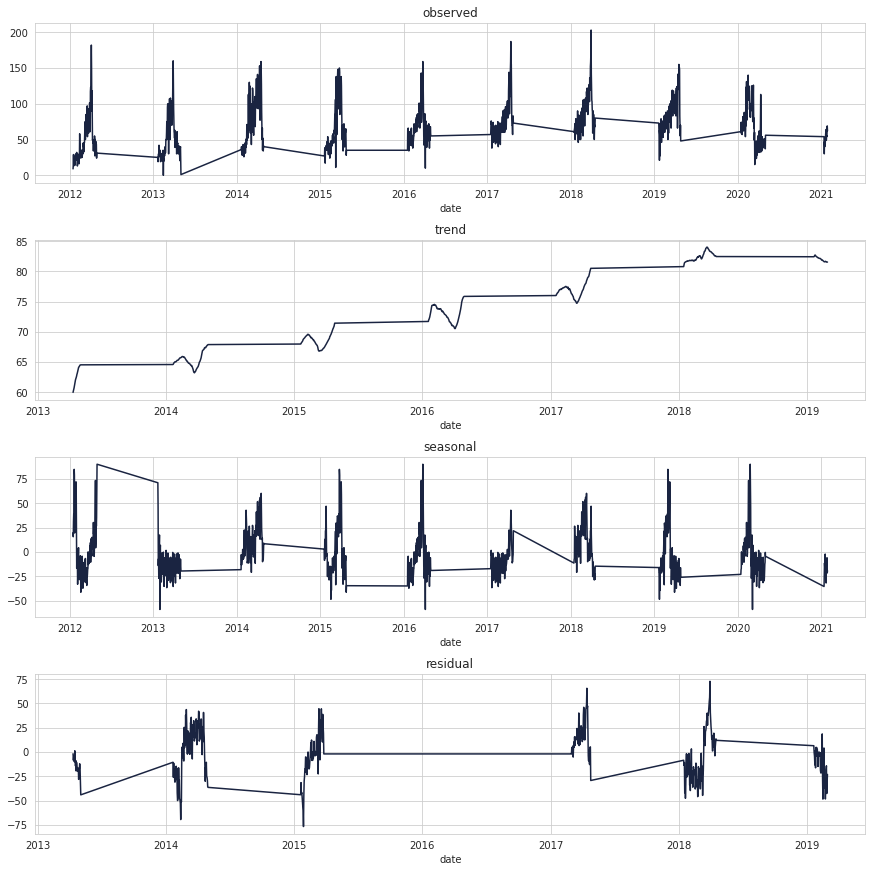

In [60]:
# Use the parameter period = 365 to extract the yearly seasonality. 
sep_yearly_one = seasonal_decompose(
    x = df_one_daily['amount_sold'],
    model='additive',
    period=365
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

sep_yearly_one.observed.plot(ax=ax[0])
ax[0].set(title='observed')
sep_yearly_one.trend.plot(ax=ax[1])
ax[1].set(title='trend')
sep_yearly_one.seasonal.plot(ax=ax[2])
ax[2].set(title='seasonal')
sep_yearly_one.resid.plot(ax=ax[3])
ax[3].set(title='residual')

plt.savefig('images/py_decompose_A1.png');
plt.show()

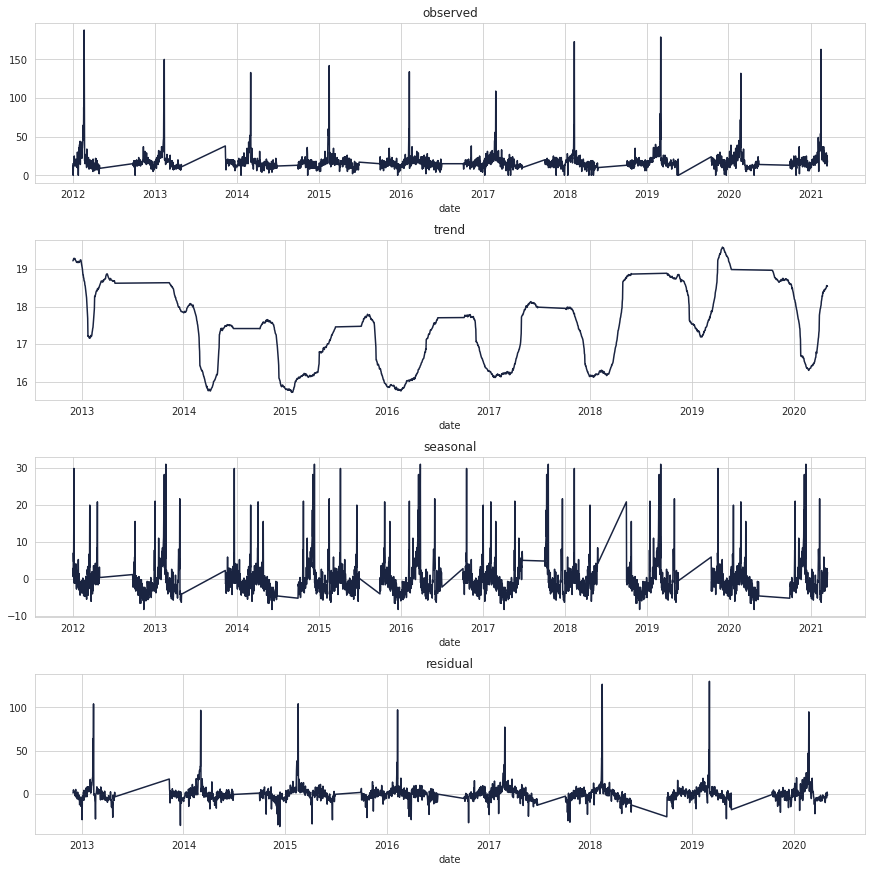

In [61]:
sep_yearly_two = seasonal_decompose(
    x = df_two_daily['amount_sold'],
    model='additive',
    period=365
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

sep_yearly_two.observed.plot(ax=ax[0])
ax[0].set(title='observed')
sep_yearly_two.trend.plot(ax=ax[1])
ax[1].set(title='trend')
sep_yearly_two.seasonal.plot(ax=ax[2])
ax[2].set(title='seasonal')
sep_yearly_two.resid.plot(ax=ax[3])
ax[3].set(title='residual')

plt.savefig('images/py_decompose_A2.png');
plt.show()

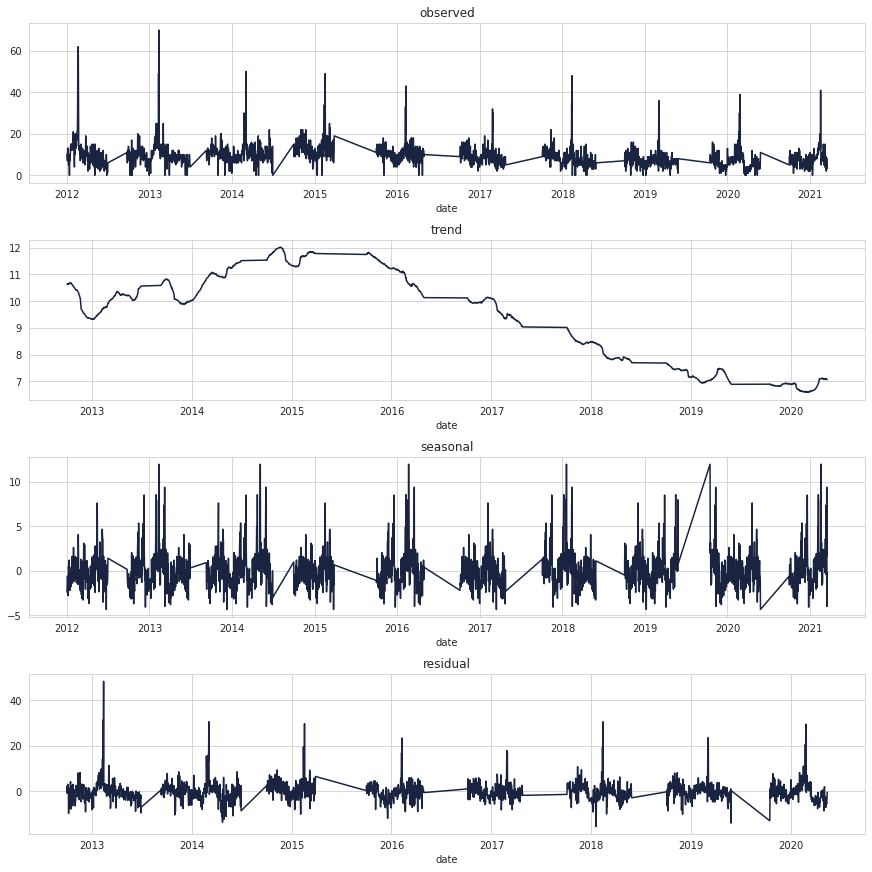

In [62]:
# Use the parameter period = 365 to extract the yearly seasonality. 
sep_yearly_three = seasonal_decompose(
    x = df_three_daily['amount_sold'],
    model='additive',
    period=365
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

sep_yearly_three.observed.plot(ax=ax[0])
ax[0].set(title='observed')
sep_yearly_three.trend.plot(ax=ax[1])
ax[1].set(title='trend')
sep_yearly_three.seasonal.plot(ax=ax[2])
ax[2].set(title='seasonal')
sep_yearly_three.resid.plot(ax=ax[3])
ax[3].set(title='residual')

plt.savefig('images/py_decompose_A3.png');
plt.show()

For reasons of simplicity, the periodicity of 365, which is usual for annual data, was used for the decomposition here. However, due to the gaps in the data, there are no 365 data points per year, so one would actually have to use a smaller value, as explained below and in the R part.

However, at this point it is mainly a matter of looking at the residuals.  Because these show a kind of seasonality in the plots. Together with the orders before (e.g. in monthly sales) one can safely say that all three ts contain multiple seasonalities.

And also the correlation investigation by means of a Ljung Box test indicates that there is still some information in them. Of course, one could also try to get this information from exogenous data, but this is not part of this project. 

### Check residuals for correlation

With a Ljung Box test

In [63]:
## vllt besser weg lassen
## limits of the Ljung Box test?

In [64]:
ljung_p = np.mean(ljung(x=sep_yearly_one.resid.dropna())[1]).round(3)
print("Ljung Box, p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")

Ljung Box, p value: 0.0 , Residuals are correlated


In [65]:
ljung_p = np.mean(ljung(x=sep_yearly_two.resid.dropna())[1]).round(3)
print("Ljung Box, p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")

Ljung Box, p value: 0.0 , Residuals are correlated


In [66]:
ljung_p = np.mean(ljung(x=sep_yearly_three.resid.dropna())[1]).round(3)
print("Ljung Box, p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")

Ljung Box, p value: 0.0 , Residuals are correlated


## Stationarity

Checking the ts for stationarity is necessary, since many models (i.e. ARIMA) require it.

Statistical stationarity means that the statistical properties (mean, variance and autocorrelation) are the same throughout the whole time series.

There are different ways for testing stationarity i.e. separate testing the statistical parameters for constants, visual  with rolling mean and rolling standard deviation or specific null-hypothesis ($H_{0}$) test. In this project I will go with two different tests and a plot for the rolling statistics.

Firstly the Augmented Dick Fuller test (adf, adfuller), with the null $H_{0}$ that there is a unit root, which means that the time series is non-stationary.

And second the Kwiatkowski-Phillips-Schmidt-Shintest (kpss) a stationary test with the opposite $H_{0}$: the time series is stationary.

With this method there are four possible cases:
+ 1. adf: not stationary $H_{0}$ & kpss: not stationary $H_{0}$ => non-stationarity
+ 2. adf: stationary $H_{0}$ & kpss stationary $H_{0}$ => stationarity
+ 3. adf: not stationary $H_{0}$ & kpss stationary $H_{0}$ => trend stationarity
+ 4. adf: stationary $H_{0}$ & kpss not stationary $H_{0}$ => difference stationarity

The importance of a unit root test can be determined by variance ratio test, which has five possible outcomes, but this is not necessary here.

But anyway a short look at the coefficient of variation $cv = std/mean$ can give a quick and easy idea  of the variability of the ts, even so it has no strict statistical definition.
+ $cv < 0$ => low variability
+ $0.75 < cv < 1.3$ => medium variability
+ $cv > 1.3$ => high variability

As a criterion for rejecting or accepting $H_{0}$, the p-value = 0.5 is used as a threshold, which is also the most common technique. For $p > 0.5 $ the $H_{0}$ gets rejected and othervise acsepted, another method would be using the confident interval of the critical values and etermined whether the p-value in it (reject) or not (accept).

The visualisation of the rolling statistic contains the original time series, the rolling mean and rolling variance. It makes it possible to see if the two vary over the time.


In [67]:
def stat_test(ts):
        
    #Determing rolling statistics
    rolmean = ts.rolling(12).mean()
    rolstd = ts.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print( )

    #  kpss test for the null hypothesis of
    # stationarity.
    ## ts (array): time series 
    ## 
    ## returns: printed test statistic and critical values
    print ('Results of KPSS Test:')
    kpsstest = kpss(ts, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    print( )
    print(f"p value:{kpsstest[1]}", ", Series is Stationary" if float(kpsstest[1]) >0.05 else ", Series is Non-Stationary")
    print( )
    print('------------------------')

    # adfuller test for the null hypothesis of
    # non-stationarity.
    ## ts (array): time series 
    ## 
    ## returns: printed test statistic and critical values
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    print( )
    print(f"p value:{dftest[1]}", ", Series is Stationary" if float(dftest[1]) <0.05 else ", Series is Non-Stationary")

In [68]:
def cv(ts):
    cv = ts.std()/ts.mean()
    if cv <= 0.75:
        return print(f'Low variability; cv = {cv}')
    if cv > 0.75 and cv <= 1.3:
        return print(f'Medium variability; cv = {cv}')
    if cv > 1.3:
        return print(f'High variability; cv = {cv}')
    
    
    #return cv.round(2)     

### Stationarity article one

In [69]:
cv(df_one.amount_sold)

Low variability; cv = 0.47298871394287284


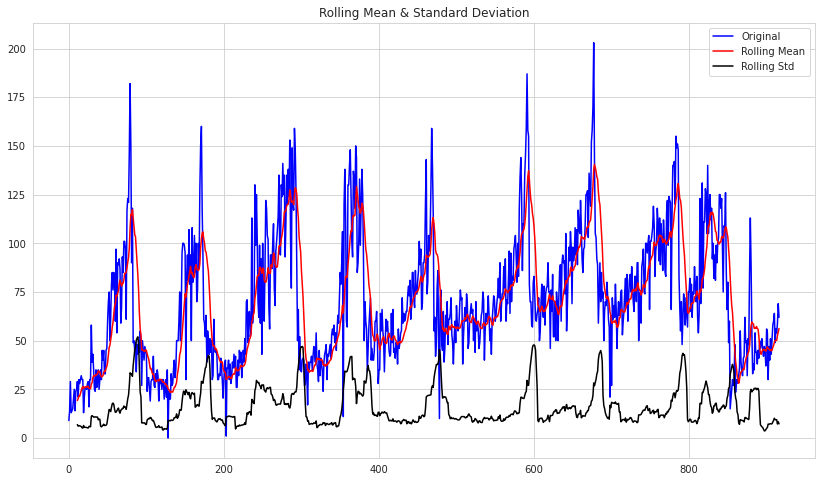


Results of KPSS Test:
Test Statistic            0.644488
p-value                   0.018592
Lags Used                21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

p value:0.018592021682809014 , Series is Non-Stationary

------------------------
Results of Dickey-Fuller Test:
Test Statistic                  -4.852744
p-value                          0.000043
#Lags Used                      14.000000
Number of Observations Used    902.000000
Critical Value (1%)             -3.437621
Critical Value (5%)             -2.864750
Critical Value (10%)            -2.568479
dtype: float64

p value:4.306443536833576e-05 , Series is Stationary


In [70]:
stat_test(df_one.amount_sold)

While the result of the adfuller test indicates, that this ts is stationary, the kpss as well as the visual test, in which not only the rolling mean, but also the rolling std trailing the up and down movement of the original ts, indicate that it is not stationary.

In conclusion looking at the list above this one is difference stationary, so it probably needs differencing to make it stationary.


### Stationarity article two

In [71]:
cv(df_two.amount_sold)

Low variability; cv = 0.6910948104575537


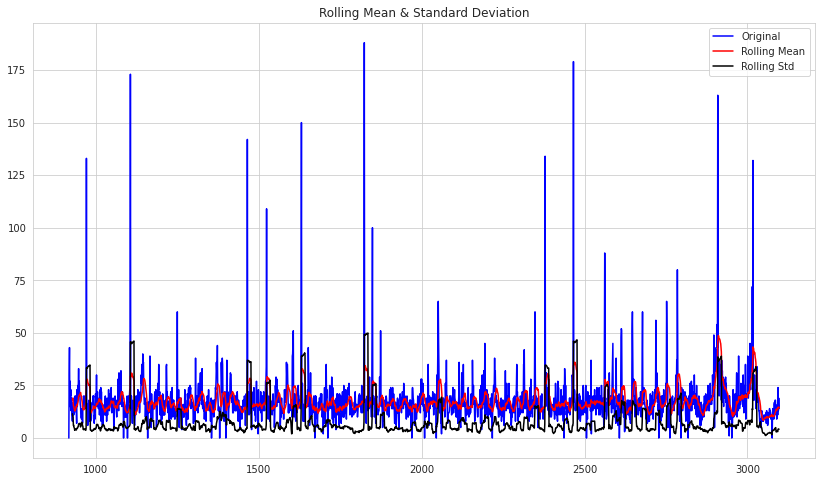


Results of KPSS Test:
Test Statistic            0.231932
p-value                   0.100000
Lags Used                26.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

p value:0.1 , Series is Stationary

------------------------
Results of Dickey-Fuller Test:
Test Statistic                  -20.980166
p-value                           0.000000
#Lags Used                        2.000000
Number of Observations Used    2178.000000
Critical Value (1%)              -3.433356
Critical Value (5%)              -2.862868
Critical Value (10%)             -2.567477
dtype: float64

p value:0.0 , Series is Stationary


In [72]:
stat_test(df_two.amount_sold)

### Stationarity article three

In [73]:
cv(df_three.amount_sold)

Low variability; cv = 0.5597234660277447


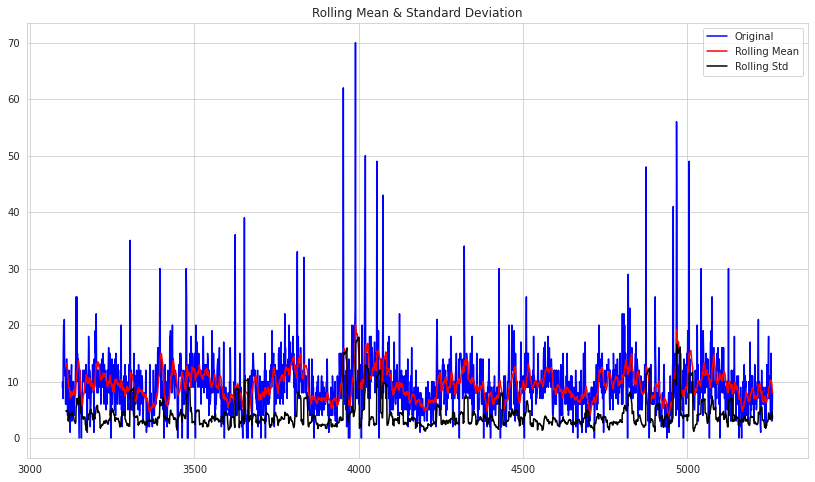


Results of KPSS Test:
Test Statistic            0.079965
p-value                   0.100000
Lags Used                26.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

p value:0.1 , Series is Stationary

------------------------
Results of Dickey-Fuller Test:
Test Statistic                -1.728158e+01
p-value                        5.777508e-30
#Lags Used                     3.000000e+00
Number of Observations Used    2.158000e+03
Critical Value (1%)           -3.433384e+00
Critical Value (5%)           -2.862880e+00
Critical Value (10%)          -2.567483e+00
dtype: float64

p value:5.777508090395563e-30 , Series is Stationary


In [74]:
stat_test(df_three.amount_sold)

The results for article two and three are the same, both tests agree that those ts are stationary. So at this point is no further action required.

### 3.8 Stationarity for article one

As shown above the time series of article one is not yet stationary. To change this there are quite a number of possibilities, such as aggregation, smoothing, transformation (e.g. log) or differencing

Lucky the disagreement of the two tests as well as some testing around with R (final chapter) suggest that only one difference should be enough to make the time series stationary.

Differencing is one of the most common methods and can deal with both trend and seasonality, by stabilising the mean. Therefore, it calculates the difference between consecutive observations.

Note: Python's statsmodel and R use mean differencing (subtracting the mean of the entire time series), while Python pandas uses Pearson correlation (mean of the subseries). 

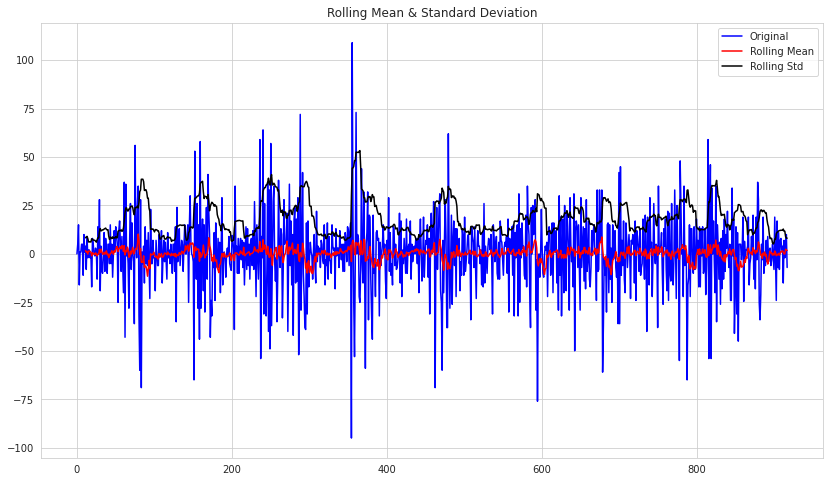


Results of KPSS Test:
Test Statistic            0.030021
p-value                   0.100000
Lags Used                21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

p value:0.1 , Series is Stationary

------------------------
Results of Dickey-Fuller Test:
Test Statistic                -8.997501e+00
p-value                        6.633414e-15
#Lags Used                     1.300000e+01
Number of Observations Used    9.030000e+02
Critical Value (1%)           -3.437612e+00
Critical Value (5%)           -2.864746e+00
Critical Value (10%)          -2.568477e+00
dtype: float64

p value:6.633414136746458e-15 , Series is Stationary


In [75]:
df_one_diff = df_one.copy()
df_one_diff.amount_sold = df_one_diff.amount_sold.diff(1).fillna(0).replace([np.inf, -np.inf], 0)

stat_test(df_one_diff.amount_sold)

# 3.9 Dominating frequencies

In order to determine the dominant frequencies, one could, for example, switch to the frequency domain or, as here, create a periodogram in time domain.

The formula required for this is: $f=\dfrac{1}{T}$ ; f - frequency, T - Period 

In [76]:
print(df_one.query('year <= 2020').info()) # -> 901 entries for 9 complet years  -> ~ 100.11 per year
print(df_two.query('year <= 2020').info()) # -> 2105 entries for 9 complet years -> ~ 233.89 per year
print(df_three.query('year <= 2020').info()) # -> 2086 entries for 9 complet years -> 231.78 per year

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901 entries, 0 to 900
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   amount_sold  901 non-null    float64       
 1   timestamp    901 non-null    datetime64[ns]
 2   date         901 non-null    object        
 3   year         901 non-null    int64         
 4   month        901 non-null    int64         
 5   week         901 non-null    int64         
 6   day          901 non-null    int64         
 7   dayofyear    901 non-null    int64         
 8   weekday      901 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 70.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2105 entries, 917 to 3097
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   amount_sold  2105 non-null   float64       
 1   timestamp 

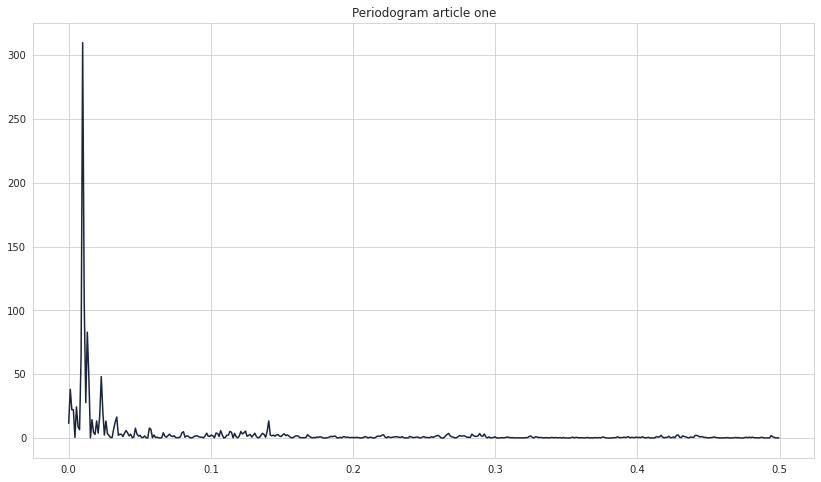

In [77]:
f, Pxx = signal.periodogram(df_one.amount_sold, window='hanning', scaling='spectrum')
plt.plot(f, Pxx)
plt.title('Periodogram article one')
plt.savefig('images/periodogram_A1.png');
plt.show()

+ $\simeq$ 0.01 -> frequ $\simeq$ 100 (knowing that there are 901 entries for 9 complete years, the exact annual period is $\simeq$ 100.11) -> main frequency / annual frequency

+ $\simeq$ 0.0129 -> $\simeq$ 77 

+ $\simeq$ 0.023 -> $\simeq$ 43.5 

+ 0.14 -> frequency 7 ($\simeq$ 0.143) -> weekly frequency.


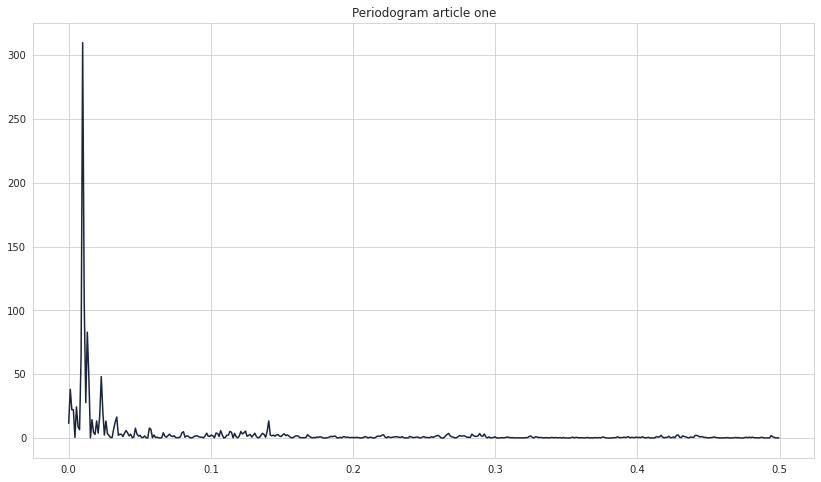

In [78]:
f, Pxx = signal.periodogram(df_one_daily.amount_sold, window='hanning', scaling='spectrum')
plt.plot(f, Pxx)
plt.title('Periodogram article one')
plt.savefig('images/periodogram_A1.png');
plt.show()

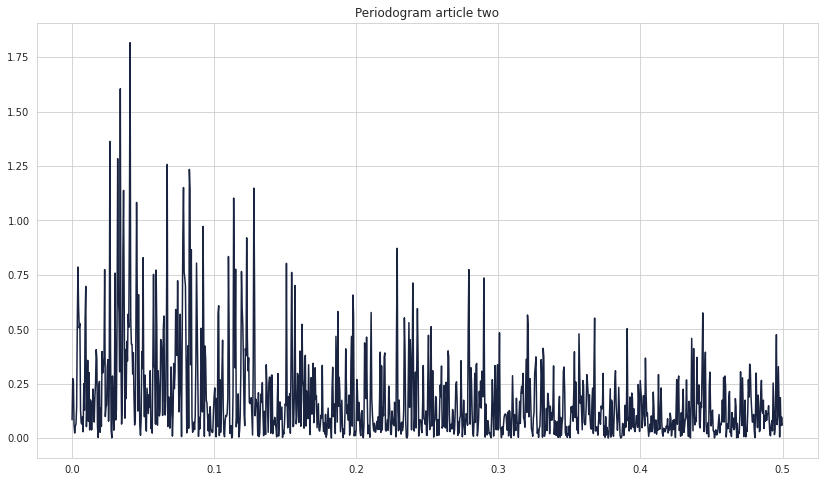

In [79]:
f, Pxx = signal.periodogram(df_two.amount_sold, window='hanning', scaling='spectrum')
plt.plot(f, Pxx)
plt.title('Periodogram article two')
plt.savefig('images/periodogram_A2.png');
plt.show()

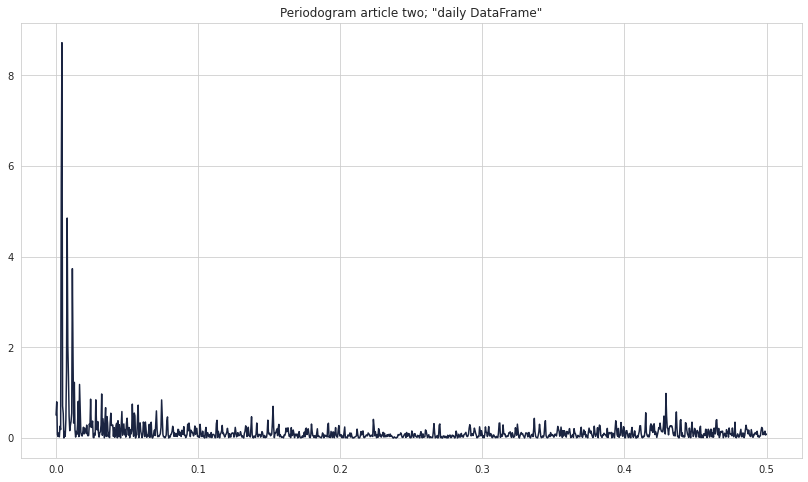

In [80]:
f, Pxx = signal.periodogram(df_two_daily.amount_sold, window='hanning', scaling='spectrum')
plt.plot(f, Pxx)
plt.title('Periodogram article two; "daily DataFrame"')
#plt.savefig('images/periodogram_A2.png');
plt.show()

+ As you can see, the periodogram of the second article shows a wild variety of peaks. It is not possible to identify the main frequencies, there are just too many of them.
+ However, it is already known from the previous studies that 233.89 is most likely the main frequency
+ From the previous research, however, it is already known that some seasonal frequencies could be useful: 7 (to catch differences between days of the week), 12 (comparison of month) and maybe 53 (comparison of weeks) frequencies, 356 (from the decomposition before)
+ The last one should possibly be checked for all articles 

+ However, it might be possible to use the 'daily DataFrames' at this point, since it does not differ statistically or in the course from the original and the corresponding periodogram shows the periods much better.

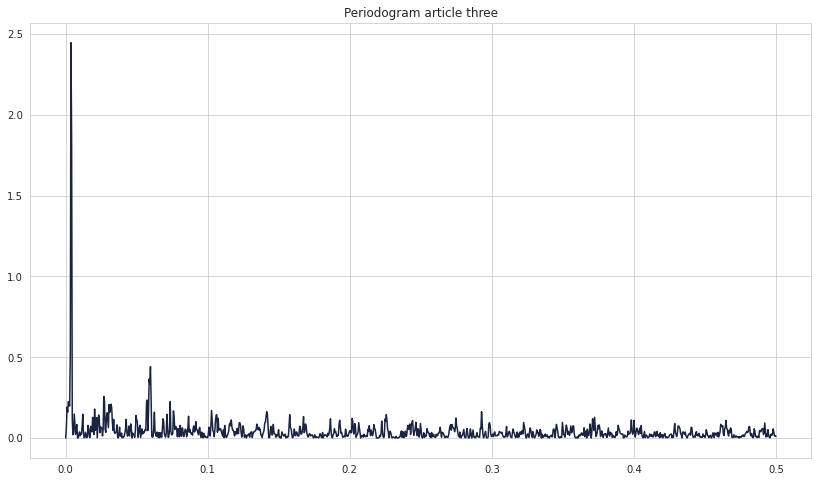

In [81]:
f, Pxx = signal.periodogram(df_three.amount_sold, window='hanning', scaling='spectrum')
plt.plot(f, Pxx)
plt.title('Periodogram article three')
plt.savefig('images/periodogram_A3.png');
plt.show()

By enlarging different parts of the curve by adjusting the x-scale back and forth:

+ $\simeq$ 0.0035 -> $\simeq$ 285.71 -> main peak, should be at 231.78 ($\simeq$ 0.0043), shift is likely due to 2021 records 
+ $\simeq$ 0.0595 -> $\simeq$ 16.80
+ If you look closely you can also see a peak for the frequency of 7 

## Normal distribution

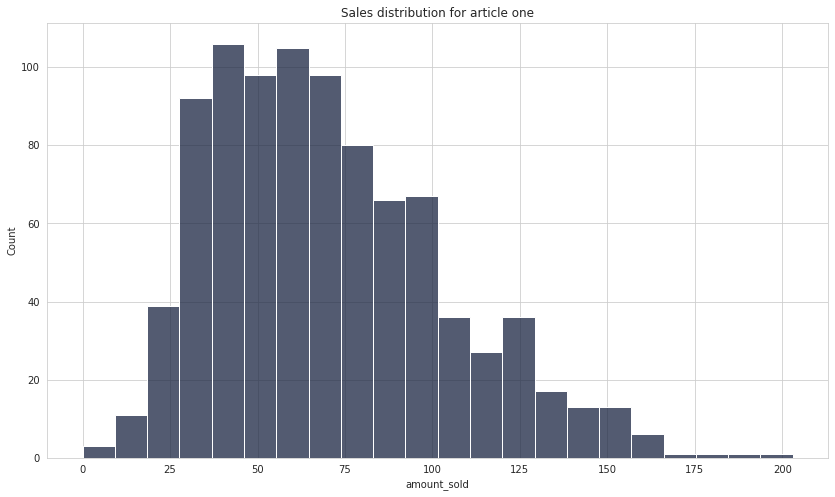

In [82]:
sns.histplot(df_one, x='amount_sold')

plt.title('Sales distribution for article one')
plt.savefig('images/distribution_A1.png');
plt.show()

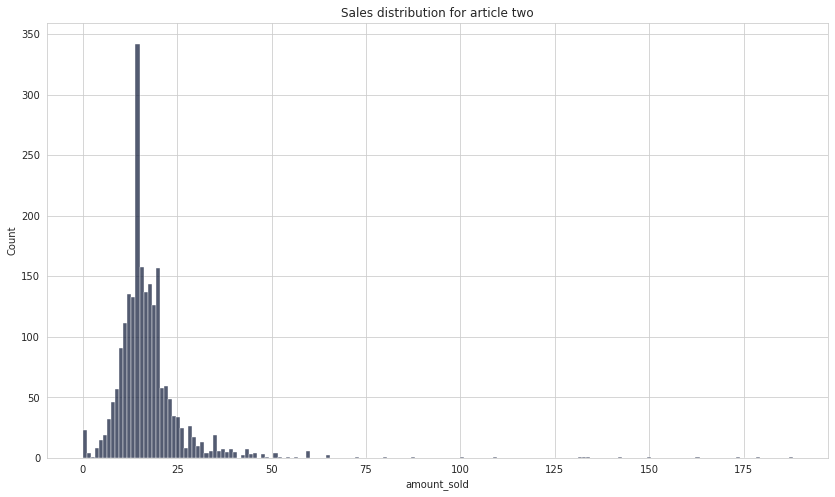

In [83]:
sns.histplot(df_two, x='amount_sold')

plt.title('Sales distribution for article two')
plt.savefig('images/distribution_A2.png');
plt.show()

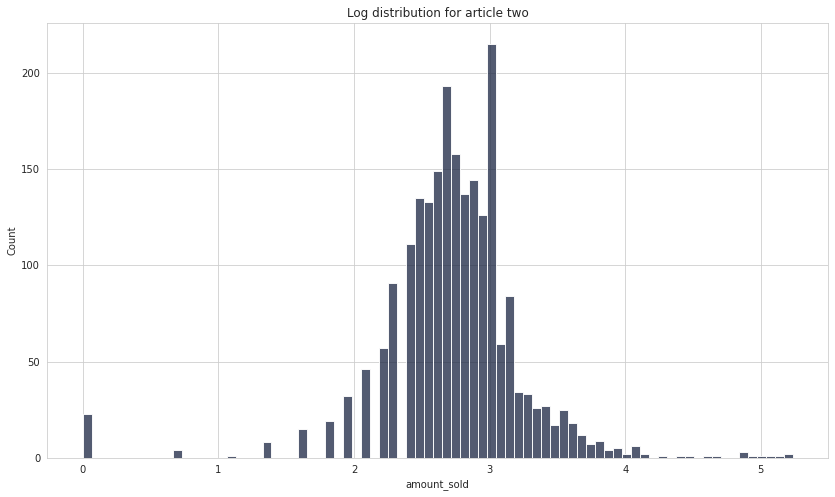

In [84]:
sns.histplot(df_two_log, x='amount_sold')
plt.title('Log distribution for article two')
plt.savefig('images/log_distribution_A2.png');
plt.show()

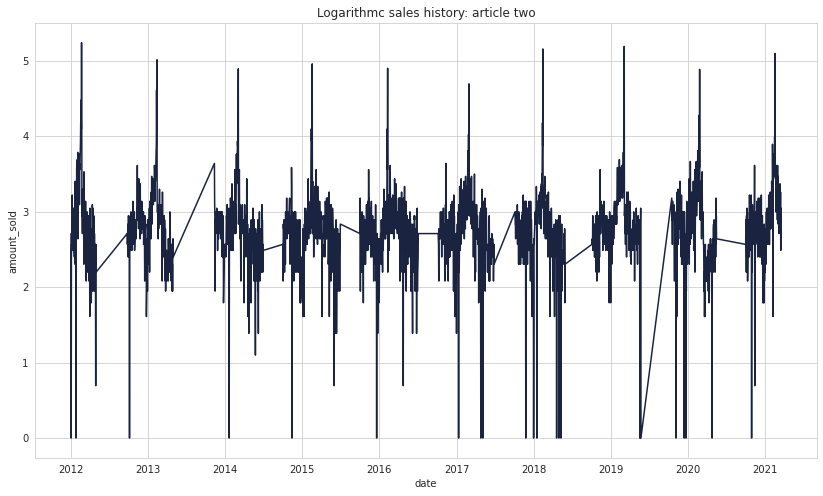

In [85]:
sns.lineplot(data=df_two_log, y='amount_sold', x='date')
plt.title('Logarithmc sales history: article two')
plt.savefig('images/log_sales_history_A2".png');
plt.show()

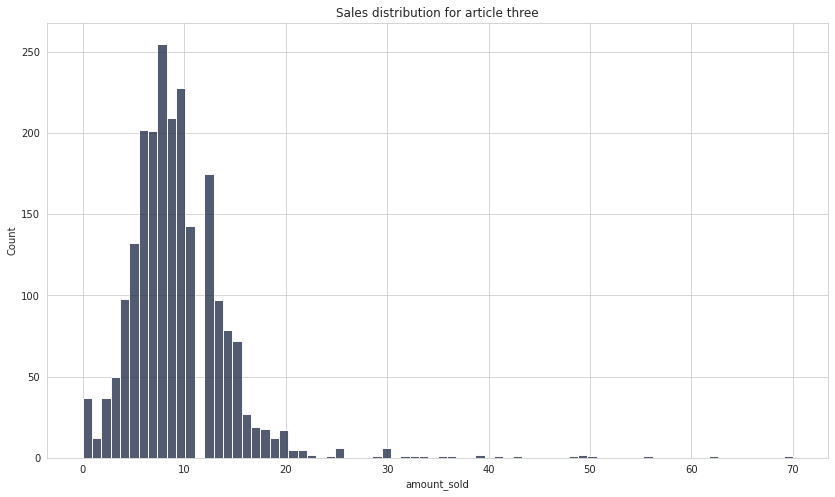

In [86]:
sns.histplot(df_three, x='amount_sold')
plt.title('Sales distribution for article three')
plt.savefig('images/distribution_A3.png');
plt.show()

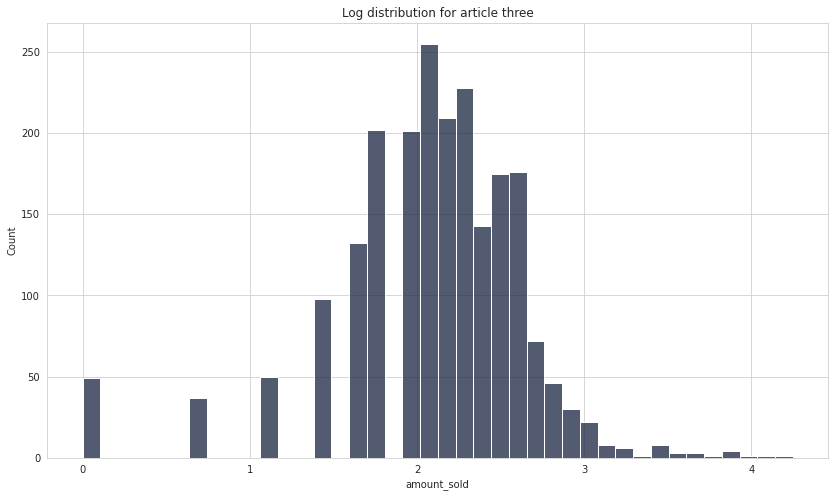

In [87]:
sns.histplot(df_three_log, x='amount_sold')
plt.title('Log distribution for article three')
plt.savefig('images/log_distribution_A3.png');
plt.show()

While the ts of article one is already normally distributed, the others on the right are skeewed. But this can be changed by means of logarithmisation. However, it should be kept in mind that this changes the course of the time series and may require a retransformation at a later stage.

# Summary

Before choosing a model, it is advisable to summarise the characteristics of the ts, because many models make certain assumptions about their characteristics, i.e. not every model is suitable for all ts.

| characteristic | article one | article two | article three | |
| :--- | :--- | :--- | :--- | :---: |
| univariate | y | y | y | - |
| NaNs | n | n | n | - |
| duplicates | n | n | n | - |
| continuous | n | n | n | possible interpolation |
| intermittent | n | n | n | - |
| stationarity | n | y | y | article one: difference stationarity needs one differencing |
| trend | n | n | n | - |
| multiple  seasonality* | y | y | y | further decomposition |
| normally distributed | y | n | n | possible logarithmization |

*Seasonalities found so far: 
+ article one: 
  + from the plots: 5 (monthly sales), 18 (weekly sales), 7 (weekdays), 365 (simple decomposition)
  + additionally periodogram: 100 (100.11; number of data points per year), 77, 43.5
  + additionally suspected: 53 (number of weeks per year)

+ article two:
  + from the plots: 12 (monthly sales), 53 (weekly sales), 7 (weekdays), 365 (simple decomposition)
  + additionally periodogram: to many
  + additionally suspected: 233.89 (number of data points per year)

+ article three:
  + from the plots:  12 (monthly sales), 53 (weekly sales), 7 (weekdays), 365 (simple decomposition)
  + additionally periodogram: 285.71 (231.78; number of data points per year), 16.88
  + additionally suspected: -

Note: Due to the focus on article one, the lists of the other two are unfortunately incomplete.

# A bit EDA with R

+ using R in Python enviroment, with rpy2
+ one line of R using %R prefix
+ whole cell of R prefix: %%R
+ convert to R object: %%R -i df 

In [88]:
%load_ext rpy2.ipython
#%reload_ext rpy2.ipython

In [89]:
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

In [90]:
r = robjects.r
base = importr('base')
forecast = importr('forecast')
graphics = importr('graphics')
grdevices = importr('grDevices')
ggplot2 = importr('ggplot2')

In [91]:
#import rpy2.dplyr as dplyr
dplyr = importr('dplyr')
urca = importr('urca')

In [92]:
zoo = importr('zoo')
xts = importr("xts", robject_translations = {".subset.xts": "_subset_xts2", 
                                             "to.period": "to_period2"})

In [93]:
seasonal = importr('seasonal')

In [94]:
Metrics = importr('Metrics')

# Global setting plot window

In [95]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command
import rpy2
old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

In [96]:
%R set.seed(1)

# Transform DataFrames
to use them in R

In [97]:
%R -i df_one 
# Transformation necessary for using in R

In [98]:
df_two.drop(columns=['date'], inplace=True)

In [99]:
%R -i df_two

In [100]:
%%R y <- ts(df_one['amount_sold'], start = 2012, end = c(2021,1), frequency = 100)

png(filename='images/R_sales_history_A1.png')
autoplot(y) +
    xlab('dayofyear') +
    ylab('amount_sold') + 
    ggtitle('Sales history article one')

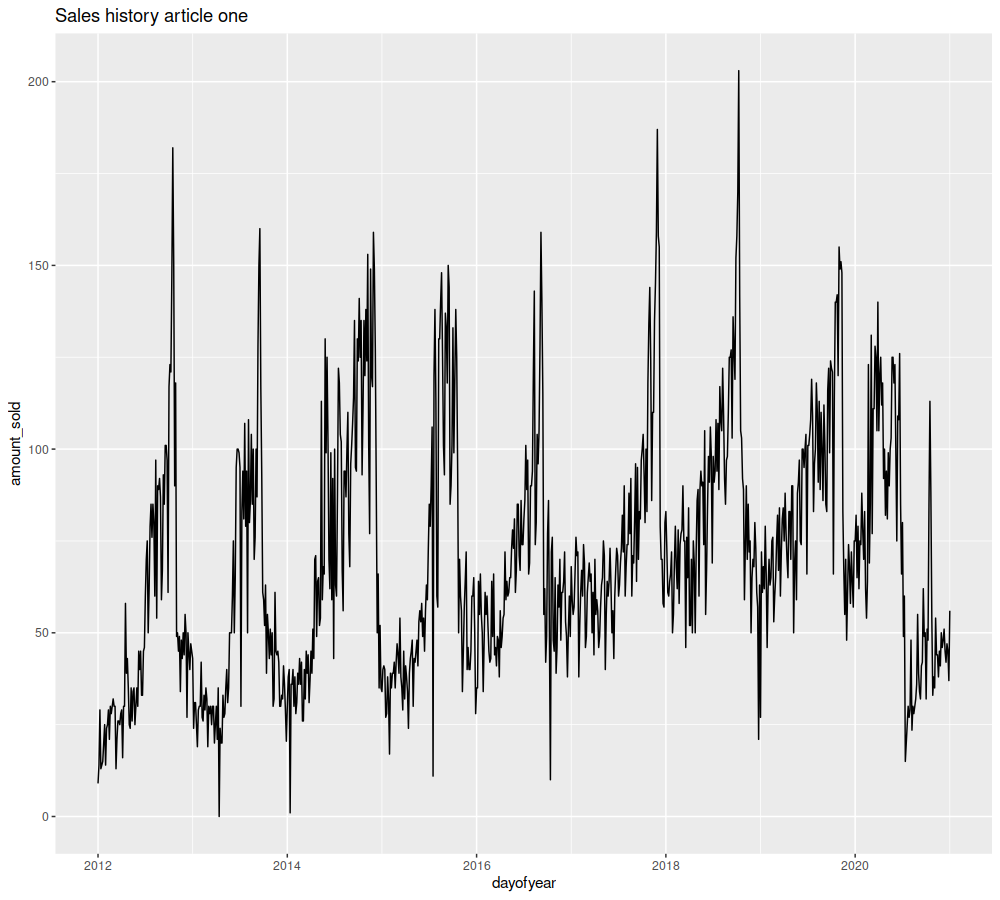

In [101]:
%%R y <- ts(df_one['amount_sold'], start = 2012, end = c(2021,1), frequency = 100)

autoplot(y) +
    xlab('dayofyear') +
    ylab('amount_sold') + 
    ggtitle('Sales history article one')

In [102]:
%%R y <- ts(df_one['amount_sold'], start = 2012, frequency = 100) 

png(filename='images/R_acf_A1.png')
p <- ggAcf(y) +
       ggtitle('ACF article one')

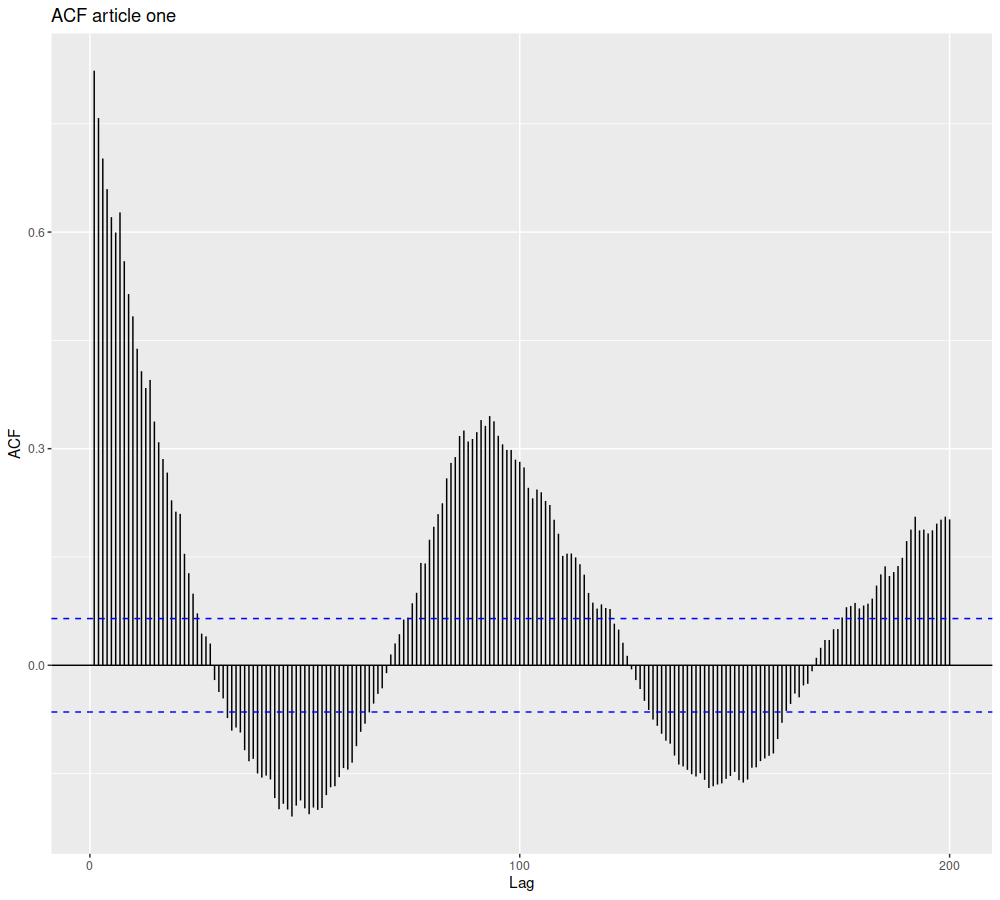

In [103]:
%%R y <- ts(df_one['amount_sold'], start = 2012, frequency = 100) 

p

In [104]:
# ts is not in the interval near 0 => no white noise

In [105]:
%%R  y <- ts(df_one['amount_sold'], start = 2012, frequency = 100)

png(filename='images/R_diff_A1.png')

y %>% diff() %>% ggtsdisplay(main="")

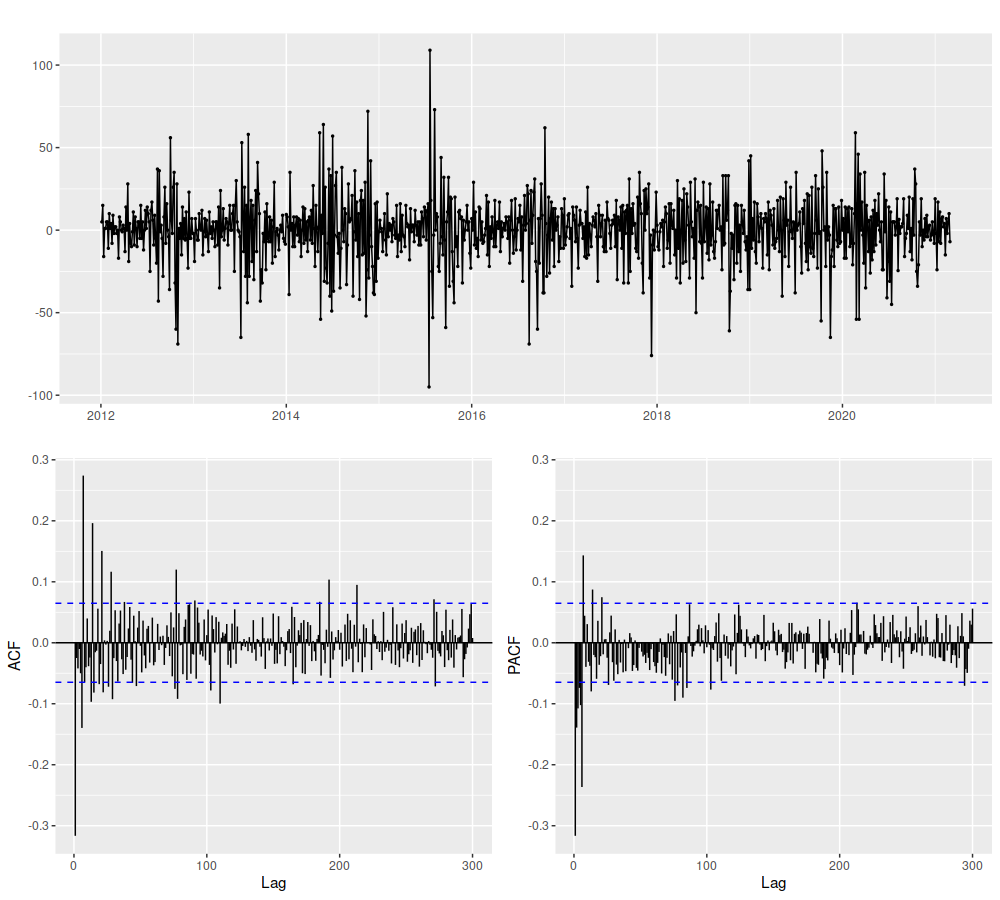

In [106]:
%%R  y <- ts(df_one['amount_sold'], start = 2012, frequency = 100)

y %>% diff() %>% ggtsdisplay(main="")


In [107]:
%%R  y <- ts(df_one['amount_sold'], start = 2012, frequency = 100)

Box.test(diff(y), lag=10, type='Ljung-Box')


	Box-Ljung test

data:  diff(y)
X-squared = 191.1, df = 10, p-value < 2.2e-16



In [108]:
%%R y <- ts(df_one['amount_sold'], start = 2012, frequency = 100)

y %>% ur.kpss() %>% summary()


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 6 lags. 

Value of test-statistic is: 1.545 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



In [109]:
%%R y <- ts(df_one['amount_sold'], start = 2012, frequency = 100)

ndiffs(y)

[1] 1


In [110]:
%%R y <- ts(df_one['amount_sold'], start = 2012, frequency = 100)

nsdiffs(y)

[1] 0


In [111]:
%%R y <- ts(df_one['amount_sold'], start = 2012, frequency = 100)

y %>% log() %>% nsdiffs()

[1] 0


In [112]:
%%R y <- ts(df_one['amount_sold'], start = 2012, frequency = 100)

y %>% log() %>% diff(lag=1) %>% ndiffs()

[1] 0


### Article two

In [113]:
%%R y2 <- ts(df_two['amount_sold'], start = 2012, frequency = 234)

p <- autoplot(y2) +
    ggtitle('Sales history article two') +
    ylab('amount_sold') +
    xlab('year')

png(filename='images/R_sales_history_A2.png')

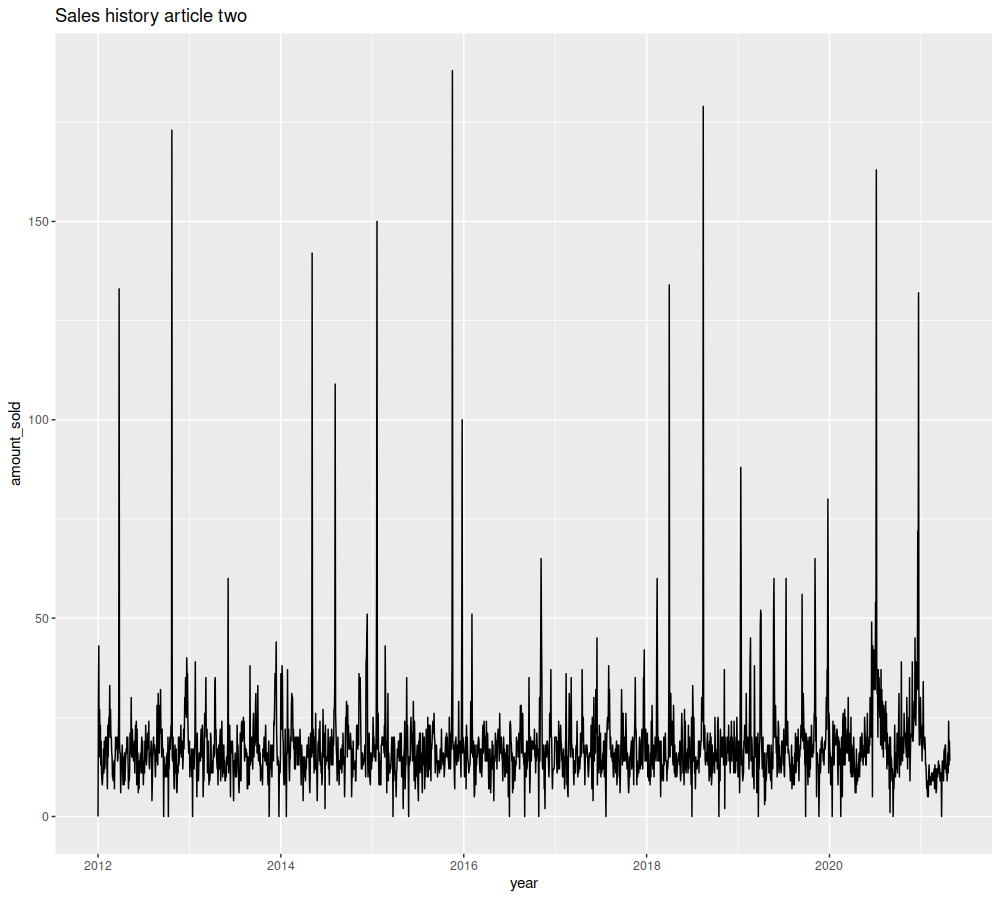

In [114]:
%%R y2 <- ts(df_two, start = 2012, frequency = 234)

p

In [115]:
%%R y2 <- ts(df_two['amount_sold'], start = 2012, frequency = 234) 

png(filename='images/R_acf_A2.png')
p <- ggAcf(y2) +
       ggtitle('ACF article two')

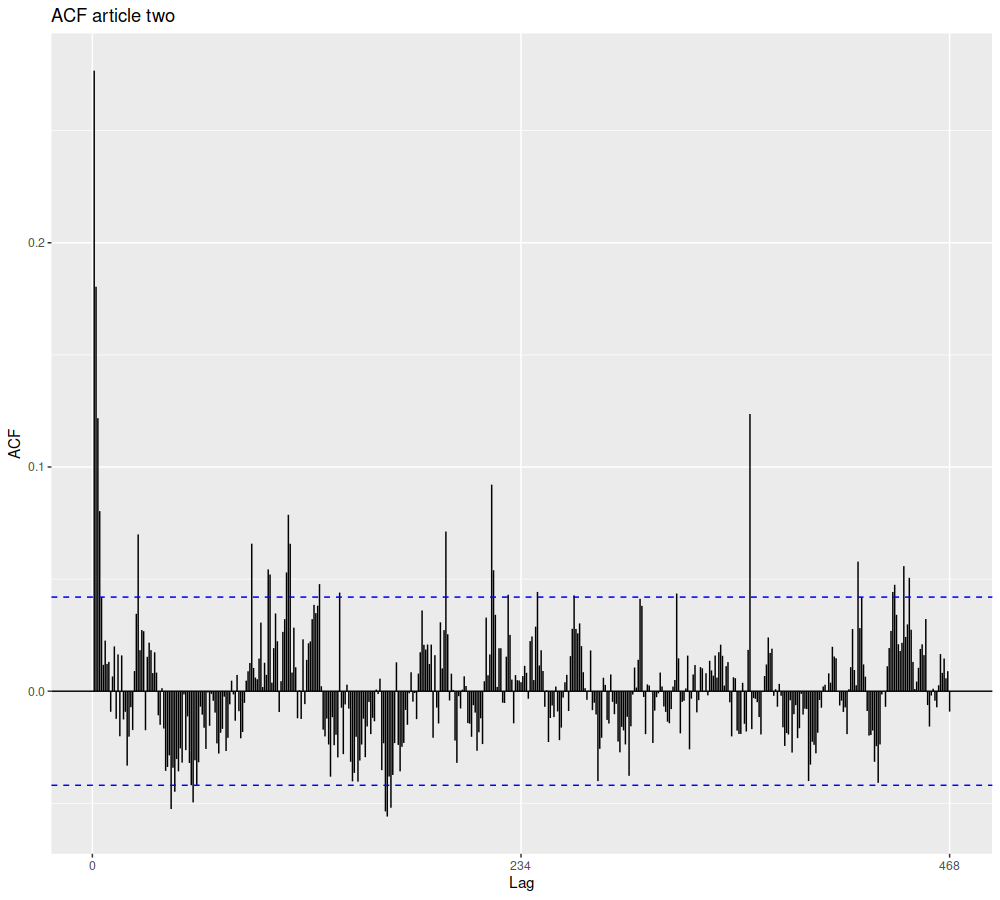

In [116]:
%%R y2 <- ts(df_two['amount_sold'], start = 2012, frequency = 234) 

p

In [117]:
%%R y2 <- ts(df_two['amount_sold'], start = 2012, frequency = 234)

y2 %>% ur.kpss() %>% summary()


####################### 
# KPSS Unit Root Test # 
####################### 

Test is of type: mu with 8 lags. 

Value of test-statistic is: 0.2627 

Critical value for a significance level of: 
                10pct  5pct 2.5pct  1pct
critical values 0.347 0.463  0.574 0.739



In [118]:
%%R y2 <- ts(df_two['amount_sold'], start = 2012, frequency = 234)

ndiffs(y2)

[1] 0


In [119]:
%%R y2 <- ts(df_two['amount_sold'], start = 2012, frequency = 234)

ndiffs(y2)

[1] 0


In [120]:
%%R y2 <- ts(df_two['amount_sold'], start = 2012, frequency = 234)

nsdiffs(y2)

[1] 0


In [121]:
%%R y2 <- ts(df_two['amount_sold'], start = 2012, frequency = 234)

y2 %>% log() %>% nsdiffs()

[1] 0


# Save all Data Frames

In [122]:
## original ts
#with open('orig_ts2.csv', 'wb') as f:
 #   pickle.dump([df_one, df_two, df_three], f)

In [123]:
# zero filled
#with open('zero_ts2.csv', 'wb') as f:
 #   pickle.dump([df_one_zero, df_two_zero, df_three_zero], f)

In [124]:
# log
#with open('log_ts2.csv', 'wb') as f:
 #   pickle.dump([df_two_log, df_three_log], f)

In [125]:
# interp
#with open('interp_ts2.csv', 'wb') as f:
 #   pickle.dump([df_one_interp, df_two_interp, df_three_interp], f)

In [126]:
# interp and log
#with open('interp_log_ts2.csv', 'wb') as f:
 #   pickle.dump([df_two_interp_log, df_three_interp_log], f)